## Library

In [1]:
import dill
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import squigglepy as sq
from squigglepy import bayes
from squigglepy.numbers import K, M, B, T

from copy import copy, deepcopy
from scipy import stats
from pprint import pprint
print('Loaded 1')

exec(open('utils.py').read())
print('Loaded 2')

exec(open('modules/tai_timelines.py').read())
print('Loaded TAI timelines module')


Loaded 1
Loaded 2
Loaded TAI timelines module


## Variables

In [2]:
# Global variables - probably don't want to change these but you could.
RUNS = 10000                                      # Number of runs to do (default 10000)
CURRENT_YEAR = 2023                               # What year to start the run on? (default: 2023)
MAX_YEAR = 2123                                   # What year to end the run on? (default: 2123)
years = list(range(CURRENT_YEAR, MAX_YEAR))

In [3]:
tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor')  # Cache generated in "Anchors" notebook
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_agi')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_turing')
# tai_flop_size = sq.sample(load_cache_file='caches/meta_anchor_metaculus_parity')
tai_flop_size = [round(t, 1) for t in tai_flop_size]
sq.get_percentiles(tai_flop_size)

{1: 24.5,
 5: 26.0,
 10: 26.8,
 20: 27.7,
 30: 28.6,
 40: 29.8,
 50: 31.4,
 60: 33.4,
 70: 35.6,
 80: 38.1,
 90: 41.7,
 95: 44.7,
 99: 50.6}

In [4]:
initial_pay = sq.sample(load_cache_file='caches/initial_pay')  # Cache generated in "Initial pay" notebook
initial_pay = [round(p, 1) for p in initial_pay]
# TODO: Suspicious this is not working in the model correctly
sq.get_percentiles(initial_pay)

{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 9.8}

In [5]:
# PROBABILITY OF A NONSCALING DELAY

# set to None to have no delay
# Otherwise specified in a dictionary
# {'delay': {'prob': <array of probabilities by year>, 'length': <distribution to sample from to get length of delay>}}

# Cache defined in "(3B) Nonscaling Delay Curve"

with open('caches/nonscaling_delays.dill', 'rb') as f:
    delay = dill.load(f)

# del delay['real_world_feedback']
# del delay['robotics']
delay

{'algorithms': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.25, sd=0.7)},
 'data': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> lognorm(mean=1.15, sd=0.7)},
 'robotics': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.47, sd=0.32)},
 'real_world_feedback': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
  'length': <Distribution> mixture
   - <Distribution> lognorm(mean=1.7, sd=0.37)
   - <Distribution> lognorm(mean=2.85, sd=0.33)},
 'policy_pause': {'prob': <function __main__.derive_nonscaling_delay_curve.<locals>.p_nonscaling_delay(year)>,
 

In [6]:
def wildeford_max_gdp_frac():
    small_project = sq.lognorm(1 / (4*K), 1 / (1*K))
    modern_megaproject = sq.lognorm(1/K, 1/600)
    old_form_megaproject = sq.lognorm(1/K, 1/150)
    gigaproject = sq.lognorm(1/150, 1/50)
    
    r_ = random.random()
    if r_ < 0.1:
        gdp_frac = small_project
        percent_spent_on_compute = sq.lognorm(0.5, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.7:
        gdp_frac = modern_megaproject
        percent_spent_on_compute = sq.lognorm(0.7, 0.95, lclip=0.1, rclip=0.999)
    elif r_ < 0.9:
        gdp_frac = old_form_megaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.95, lclip=0.1, rclip=0.999)
    else:
        gdp_frac = gigaproject
        percent_spent_on_compute = sq.lognorm(0.85, 0.99, lclip=0.1, rclip=0.999)
        
    models_trained_per_year_for_budget = sq.lognorm(1, 10)

    frac = ~gdp_frac * ~percent_spent_on_compute / ~models_trained_per_year_for_budget
    
    return (1 / (4*K)) if frac < (1 / (4*K)) else frac


variables = {'initial_gdp': 23*T,
             'tai_flop_size': tai_flop_size,
             'algo_doubling_rate_max': 3,
             'algo_doubling_rate_min': 1,
             'min_reduction': 2,
             'max_reduction': 5,
             'initial_flop_per_dollar': 18.3,
             'flop_halving_rate': sq.norm(2, 3),         # https://epochai.org/blog/predicting-gpu-performance
             'max_flop_per_dollar': sq.lognorm(21, 24),  # https://epochai.org/blog/predicting-gpu-performance
             'initial_pay': initial_pay,
             'gdp_growth': sq.lognorm(1.01, 1.035, lclip=1.005),
             'max_gdp_frac': wildeford_max_gdp_frac, # TODO: Willingness to spend connected to commercialization
             'spend_doubling_time': sq.norm(1.5, 4.5, lclip=1),
             '2025_spend_doubling_time': sq.norm(0.93, 1.05, lclip=0.9),
             'nonscaling_delay': delay}

print('Loaded')


Loaded


## GDP Frac

In [7]:
gdp_frac_samples = sq.sample(wildeford_max_gdp_frac, verbose=True, n=5000)
sq.get_percentiles(gdp_frac_samples)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 193273.43it/s]


{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00030249076291058457,
 50: 0.0003893266296794018,
 60: 0.0004977863563321082,
 70: 0.0006747794497726341,
 80: 0.0010283340584655533,
 90: 0.002182606532477829,
 95: 0.0039014323306932087,
 99: 0.009697347675986418}

In [8]:
gdp_samples = [g * variables['initial_gdp'] for g in gdp_frac_samples]
sq.get_log_percentiles(gdp_samples)

{1: '5.8e+09',
 5: '5.8e+09',
 10: '5.8e+09',
 20: '5.8e+09',
 30: '5.8e+09',
 40: '7.0e+09',
 50: '9.0e+09',
 60: '1.1e+10',
 70: '1.6e+10',
 80: '2.4e+10',
 90: '5.0e+10',
 95: '9.0e+10',
 99: '2.2e+11'}

## Run Wildeford timelines model

-
-
## SAMPLE RUN 1 ##
It takes 31.9 log FLOP (~79 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~575 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~852 million). This doubles every 1.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.043x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 31.9 log FLOP (79 nonillion) - log $ 13.6 to buy TAI (40 trillion) vs. willingness to pay log $ 8.9 (742 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.4 max log FLOP (3 octillion) available - TAI takes 31.8 log FLOP (61 nonillion) - log $ 13.4 to buy TAI (23 trillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.7 max log FLOP (5 octillion) available - TAI t

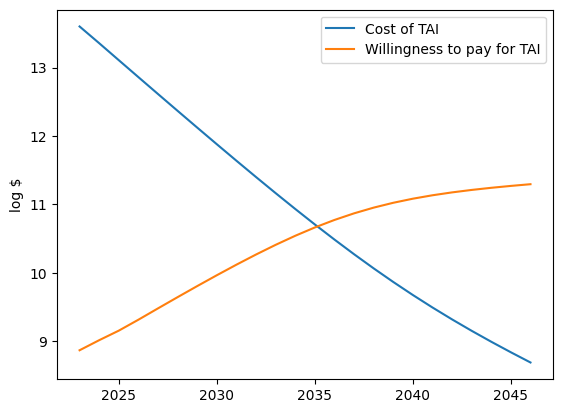

-
-
## SAMPLE RUN 2 ##
It takes 29.2 log FLOP (~158 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~212 sextillion) per 2022$USD.
We are initially willing to pay 8.9 log 2022$USD (~761 million). This doubles every 1.0 years until 2025, and then doubles every 1 years to a max of 0.078021% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.2 max log FLOP (1 octillion) available - TAI takes 29.2 log FLOP (158 octillion) - log $ 10.9 to buy TAI (79 billion) vs. willingness to pay log $ 8.9 (730 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.6 max log FLOP (4 octillion) available - TAI takes 29.1 log FLOP (127 octillion) - log $ 10.7 to buy TAI (48 billion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27

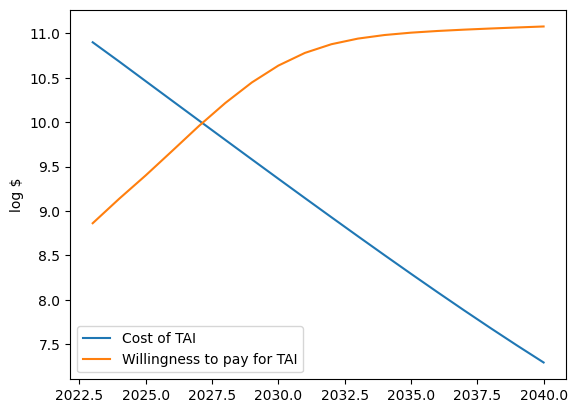

-
-
## SAMPLE RUN 3 ##
It takes 28.7 log FLOP (~50 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 20.9 log FLOP (~785 quintillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 3.3 years to a max of 0.027997% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 28.7 log FLOP (50 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (304 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.2 to buy TAI (16 billion) vs. willingness to pay log $ 8.1 (119 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (477 septillion) availa

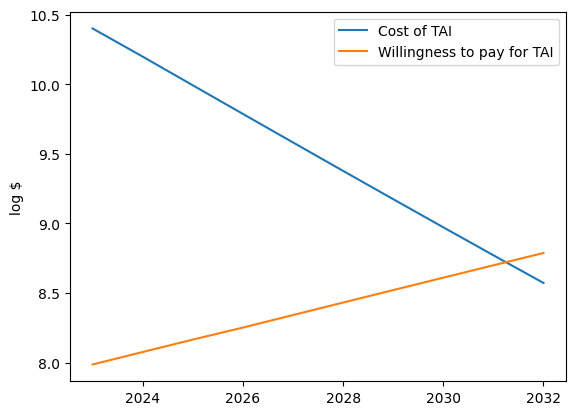

-
-
## RUN TIMELINES MODEL ##
Generating Bayes net with 5 cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:33<00:00, 106.72it/s]


Shuffling data...
Waiting for other cores...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 549.51it/s]


...Collected!
Caching in-memory...
...Cached!
Writing cache to file `caches/tai_years.sqcache`...
...Cached!
...Reducing
...Reduced!
...All done!
-
## DISTRIBUTION OF TAI ARRIVAL DATE ##
['5%: 2030',
 '10%: 2032',
 '15%: 2033',
 '20%: 2034',
 '25%: 2036',
 '35%: 2038',
 '50%: 2043',
 '60%: 2050',
 '75%: 2089',
 '80%: >2123',
 '90%: >2123',
 '95%: >2123']
-
-
## DISTRIBUTION OF RELATIVE TAI ARRIVAL DATE ##
['5%: 7 years from now',
 '10%: 9 years from now',
 '15%: 10 years from now',
 '20%: 11 years from now',
 '25%: 13 years from now',
 '35%: 15 years from now',
 '50%: 20 years from now',
 '60%: 27 years from now',
 '75%: 66 years from now',
 '80%: >100 years from now',
 '90%: >100 years from now',
 '95%: >100 years from now']
-
-
## TAI ARRIVAL DATE BY BIN ##
This year: 0.0%
2024-2027: 0.0%
2028-2029: 2.6%
2030-2034: 17.8%
2035-2039: 20.5%
2040-2049: 18.6%
2050-2059: 8.6%
2060-2069: 4.1%
2070-2079: 1.7%
2080-2089: 1.0%
2090-2099: 0.6%
2100-2109: 0.5%
2110-2119: 0.6%
>2120: 23.2%
-
-
##

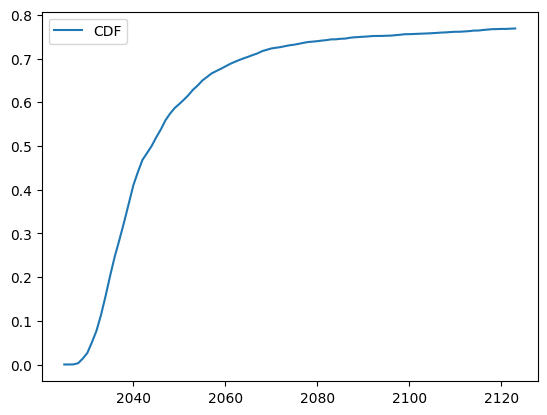

<string>:162: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#d

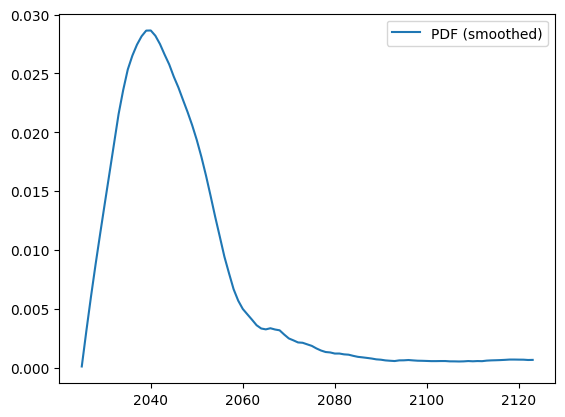

-
-
## TAI FLOP SIZE ##
{1: 24.7,
 5: 25.9,
 10: 26.6,
 20: 27.6,
 30: 28.4,
 40: 29.4,
 50: 31.2,
 60: 33.1,
 70: 35.5,
 80: 37.9,
 90: 40.9,
 95: 44.6,
 99: 49.3}


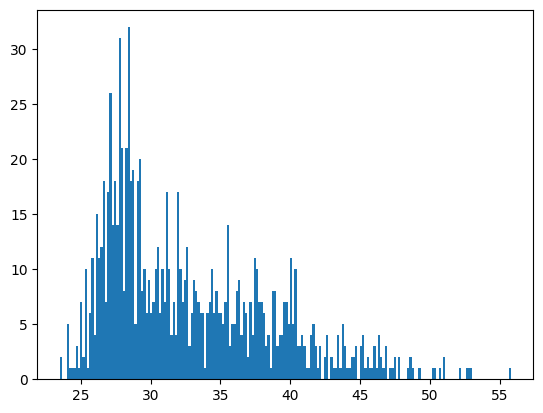

-
-
## MIN REDUCTION: 2 ##
-
## MAX REDUCTION: 5 ##
-
## MIN ALGO DOUBLING RATE: 1 ##
-
## MAX ALGO DOUBLING RATE: 3 ##
-
## INITIAL FLOP PER DOLLAR: 18.3 ##
-
## FLOP HALVING RATE ##
{1: 3.2,
 5: 3.0,
 10: 2.9,
 20: 2.8,
 30: 2.7,
 40: 2.6,
 50: 2.5,
 60: 2.4,
 70: 2.3,
 80: 2.2,
 90: 2.1,
 95: 2.0,
 99: 1.8}


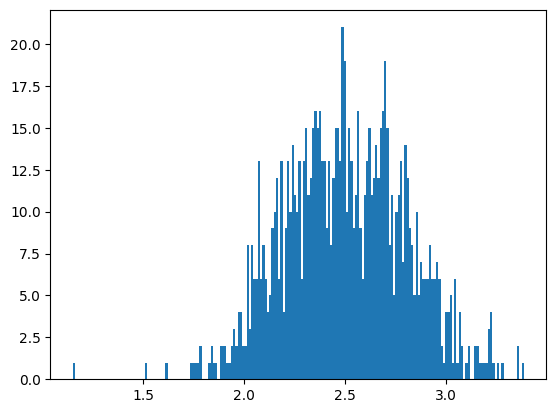

-
-
## MAX FLOP PER DOLLAR ##
{1: 20.4,
 5: 21.0,
 10: 21.3,
 20: 21.7,
 30: 22.0,
 40: 22.2,
 50: 22.5,
 60: 22.7,
 70: 22.9,
 80: 23.2,
 90: 23.5,
 95: 23.9,
 99: 24.6}


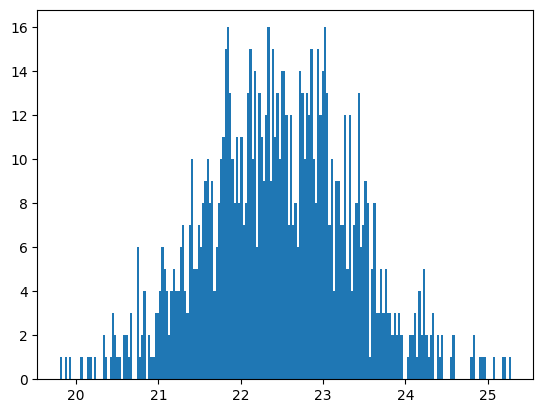

-
-
## INITIAL PAY ##
{1: 7.4,
 5: 7.6,
 10: 7.7,
 20: 7.9,
 30: 8.0,
 40: 8.1,
 50: 8.2,
 60: 8.3,
 70: 8.5,
 80: 8.7,
 90: 9.0,
 95: 9.3,
 99: 10.0}


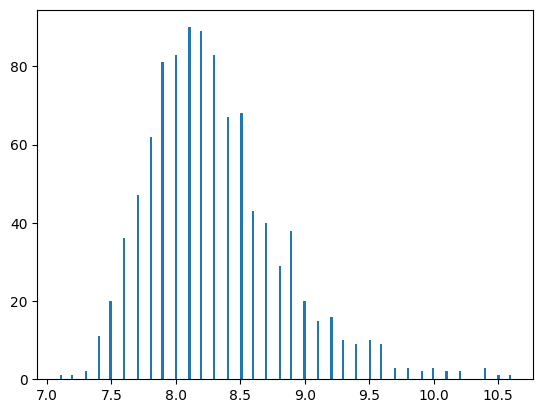

-
-
## GDP GROWTH ##
{1: 1.01,
 5: 1.01,
 10: 1.01,
 20: 1.02,
 30: 1.02,
 40: 1.02,
 50: 1.02,
 60: 1.02,
 70: 1.03,
 80: 1.03,
 90: 1.03,
 95: 1.03,
 99: 1.04}


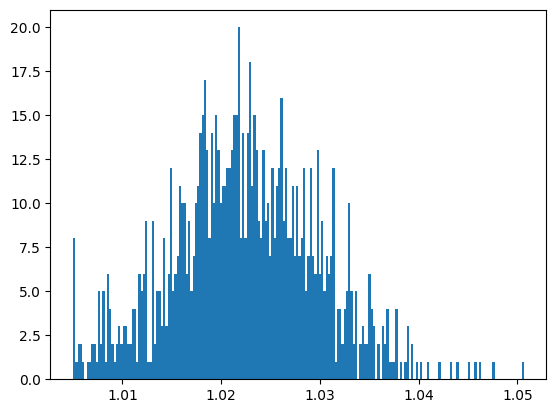

-
-
## MAX GDP FRAC ##
{1: 0.00025,
 5: 0.00025,
 10: 0.00025,
 20: 0.00025,
 30: 0.00025,
 40: 0.00032,
 50: 0.00041,
 60: 0.00054,
 70: 0.00077,
 80: 0.00109,
 90: 0.00232,
 95: 0.00383,
 99: 0.00907}


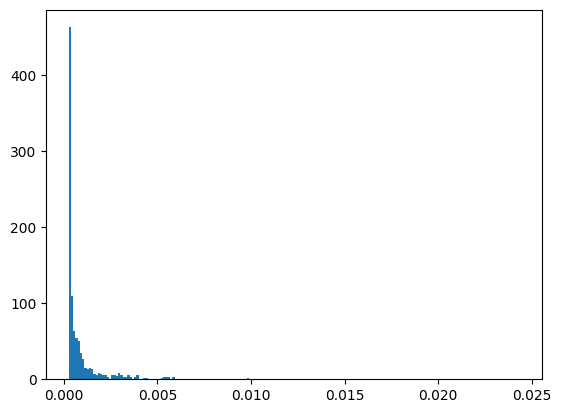

-
-
## SPEND DOUBLING TIME ##
{1: 5.1,
 5: 4.5,
 10: 4.1,
 20: 3.7,
 30: 3.5,
 40: 3.2,
 50: 3.0,
 60: 2.7,
 70: 2.5,
 80: 2.1,
 90: 1.8,
 95: 1.5,
 99: 1.0}


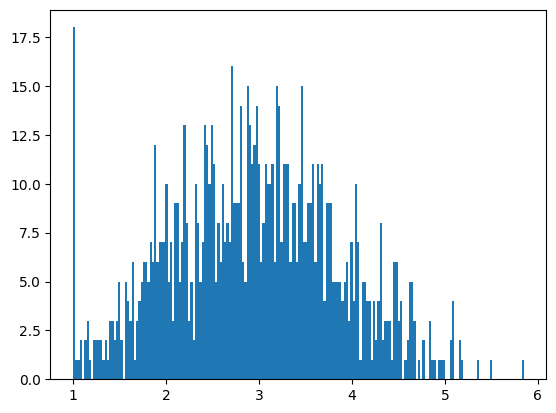

-
-
-
-
## GDP Over Time ##


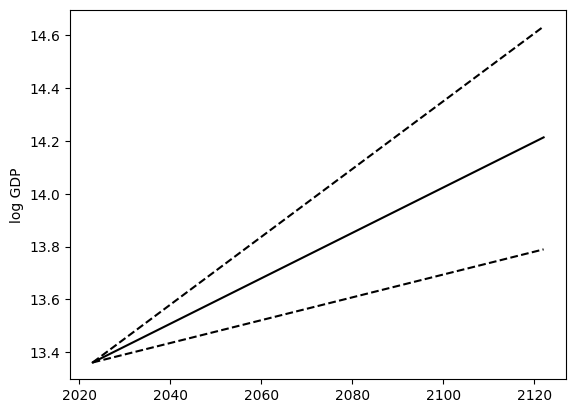

Year: 2023 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~23 trillion)
Year: 2024 - GDP log 2022$USD 13.4 (~23 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2025 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~23 trillion) - 13.4 (~24 trillion)
Year: 2026 - GDP log 2022$USD 13.4 (~24 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~25 trillion)
Year: 2027 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~26 trillion)
Year: 2028 - GDP log 2022$USD 13.4 (~25 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2029 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~24 trillion) - 13.4 (~27 trillion)
Year: 2030 - GDP log 2022$USD 13.4 (~26 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~28 trillion)
Year: 2031 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~29 trillion)
Year: 2032 - GDP log 2022$USD 13.4 (~27 trillion) 90% CI 13.4 (~25 trillion) - 13.5 (~30 trillion)
Year: 2033

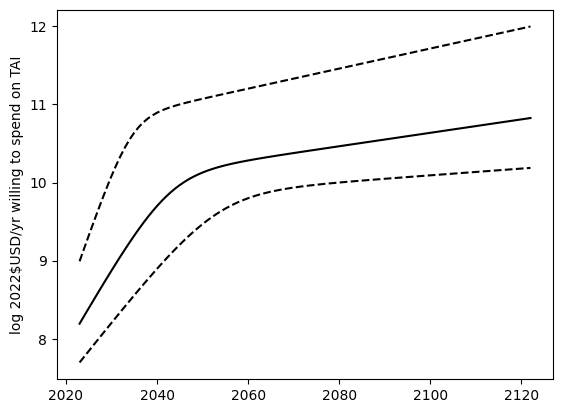

Year: 2023 - willingness log 2022$USD per year 8.2 (~156 million) 90% CI 7.7 (~50 million) - 9.0 (~982 million)
Year: 2024 - willingness log 2022$USD per year 8.3 (~196 million) 90% CI 7.8 (~59 million) - 9.2 (~1 billion)
Year: 2025 - willingness log 2022$USD per year 8.4 (~245 million) 90% CI 7.8 (~69 million) - 9.3 (~2 billion)
Year: 2026 - willingness log 2022$USD per year 8.5 (~307 million) 90% CI 7.9 (~82 million) - 9.5 (~3 billion)
Year: 2027 - willingness log 2022$USD per year 8.6 (~384 million) 90% CI 8.0 (~97 million) - 9.6 (~4 billion)
Year: 2028 - willingness log 2022$USD per year 8.7 (~480 million) 90% CI 8.1 (~114 million) - 9.8 (~6 billion)
Year: 2029 - willingness log 2022$USD per year 8.8 (~598 million) 90% CI 8.1 (~135 million) - 9.9 (~9 billion)
Year: 2030 - willingness log 2022$USD per year 8.9 (~744 million) 90% CI 8.2 (~159 million) - 10.1 (~12 billion)
Year: 2031 - willingness log 2022$USD per year 9.0 (~922 million) 90% CI 8.3 (~188 million) - 10.2 (~16 billion)


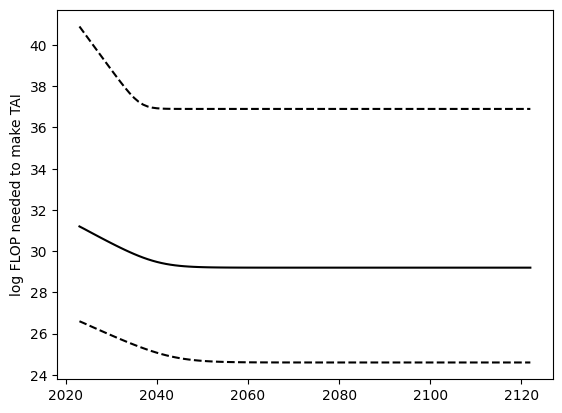

Year: 2023 - log FLOP needed for TAI 31.2 (~16 nonillion) 90% CI 26.6 (~398 septillion) - 40.9 (~79 million decillion)
Year: 2024 - log FLOP needed for TAI 31.1 (~12 nonillion) 90% CI 26.5 (~320 septillion) - 40.6 (~40 million decillion)
Year: 2025 - log FLOP needed for TAI 31.0 (~9 nonillion) 90% CI 26.4 (~255 septillion) - 40.3 (~20 million decillion)
Year: 2026 - log FLOP needed for TAI 30.8 (~7 nonillion) 90% CI 26.3 (~203 septillion) - 40.0 (~10 million decillion)
Year: 2027 - log FLOP needed for TAI 30.7 (~5 nonillion) 90% CI 26.2 (~162 septillion) - 39.7 (~5 million decillion)
Year: 2028 - log FLOP needed for TAI 30.6 (~4 nonillion) 90% CI 26.1 (~129 septillion) - 39.4 (~2 million decillion)
Year: 2029 - log FLOP needed for TAI 30.5 (~3 nonillion) 90% CI 26.0 (~104 septillion) - 39.1 (~1 million decillion)
Year: 2030 - log FLOP needed for TAI 30.4 (~2 nonillion) 90% CI 25.9 (~83 septillion) - 38.8 (~629 thousand decillion)
Year: 2031 - log FLOP needed for TAI 30.3 (~2 nonillion)

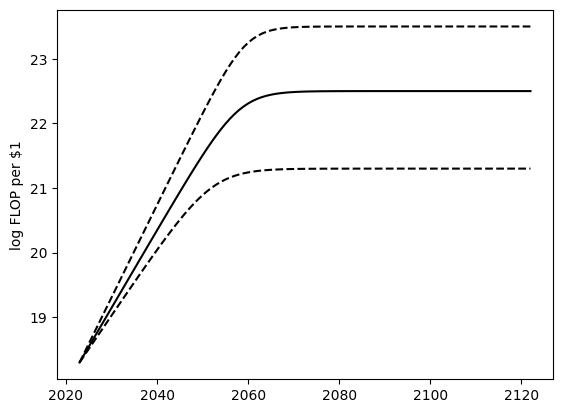

Year: 2023 - log FLOP per 2022$1USD 18.3 (~2 quintillion) 90% CI 18.3 (~2 quintillion) - 18.3 (~2 quintillion)
Year: 2024 - log FLOP per 2022$1USD 18.4 (~3 quintillion) 90% CI 18.4 (~3 quintillion) - 18.4 (~3 quintillion)
Year: 2025 - log FLOP per 2022$1USD 18.5 (~3 quintillion) 90% CI 18.5 (~3 quintillion) - 18.6 (~4 quintillion)
Year: 2026 - log FLOP per 2022$1USD 18.7 (~5 quintillion) 90% CI 18.6 (~4 quintillion) - 18.7 (~5 quintillion)
Year: 2027 - log FLOP per 2022$1USD 18.8 (~6 quintillion) 90% CI 18.7 (~5 quintillion) - 18.9 (~7 quintillion)
Year: 2028 - log FLOP per 2022$1USD 18.9 (~8 quintillion) 90% CI 18.8 (~7 quintillion) - 19.0 (~10 quintillion)
Year: 2029 - log FLOP per 2022$1USD 19.0 (~11 quintillion) 90% CI 18.9 (~8 quintillion) - 19.2 (~14 quintillion)
Year: 2030 - log FLOP per 2022$1USD 19.1 (~14 quintillion) 90% CI 19.0 (~11 quintillion) - 19.3 (~20 quintillion)
Year: 2031 - log FLOP per 2022$1USD 19.3 (~18 quintillion) 90% CI 19.1 (~13 quintillion) - 19.4 (~28 quint

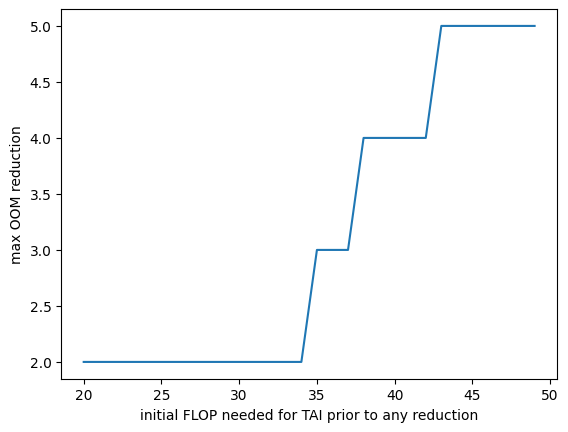

TAI log FLOP 20 -> 2.0 OOM reductions possible
TAI log FLOP 21 -> 2.0 OOM reductions possible
TAI log FLOP 22 -> 2.0 OOM reductions possible
TAI log FLOP 23 -> 2.0 OOM reductions possible
TAI log FLOP 24 -> 2.0 OOM reductions possible
TAI log FLOP 25 -> 2.0 OOM reductions possible
TAI log FLOP 26 -> 2.0 OOM reductions possible
TAI log FLOP 27 -> 2.0 OOM reductions possible
TAI log FLOP 28 -> 2.0 OOM reductions possible
TAI log FLOP 29 -> 2.0 OOM reductions possible
TAI log FLOP 30 -> 2.0 OOM reductions possible
TAI log FLOP 31 -> 2.0 OOM reductions possible
TAI log FLOP 32 -> 2.0 OOM reductions possible
TAI log FLOP 33 -> 2.0 OOM reductions possible
TAI log FLOP 34 -> 2.0 OOM reductions possible
TAI log FLOP 35 -> 3.0 OOM reductions possible
TAI log FLOP 36 -> 3.0 OOM reductions possible
TAI log FLOP 37 -> 3.0 OOM reductions possible
TAI log FLOP 38 -> 4.0 OOM reductions possible
TAI log FLOP 39 -> 4.0 OOM reductions possible
TAI log FLOP 40 -> 4.0 OOM reductions possible
TAI log FLOP 

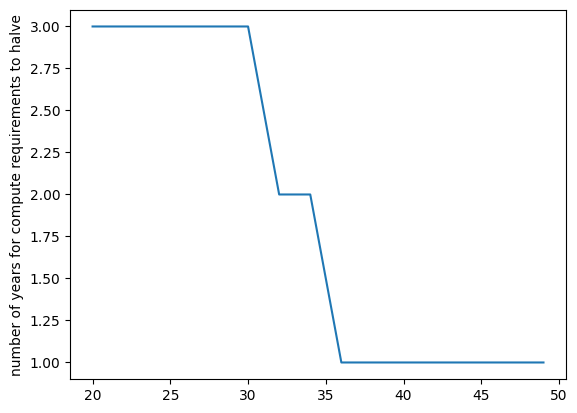

TAI log FLOP 20 -> algo doubling rate 3.0yrs
TAI log FLOP 21 -> algo doubling rate 3.0yrs
TAI log FLOP 22 -> algo doubling rate 3.0yrs
TAI log FLOP 23 -> algo doubling rate 3.0yrs
TAI log FLOP 24 -> algo doubling rate 3.0yrs
TAI log FLOP 25 -> algo doubling rate 3.0yrs
TAI log FLOP 26 -> algo doubling rate 3.0yrs
TAI log FLOP 27 -> algo doubling rate 3.0yrs
TAI log FLOP 28 -> algo doubling rate 3.0yrs
TAI log FLOP 29 -> algo doubling rate 3.0yrs
TAI log FLOP 30 -> algo doubling rate 3.0yrs
TAI log FLOP 31 -> algo doubling rate 2.5yrs
TAI log FLOP 32 -> algo doubling rate 2.0yrs
TAI log FLOP 33 -> algo doubling rate 2.0yrs
TAI log FLOP 34 -> algo doubling rate 2.0yrs
TAI log FLOP 35 -> algo doubling rate 1.5yrs
TAI log FLOP 36 -> algo doubling rate 1.0yrs
TAI log FLOP 37 -> algo doubling rate 1.0yrs
TAI log FLOP 38 -> algo doubling rate 1.0yrs
TAI log FLOP 39 -> algo doubling rate 1.0yrs
TAI log FLOP 40 -> algo doubling rate 1.0yrs
TAI log FLOP 41 -> algo doubling rate 1.0yrs
TAI log FL

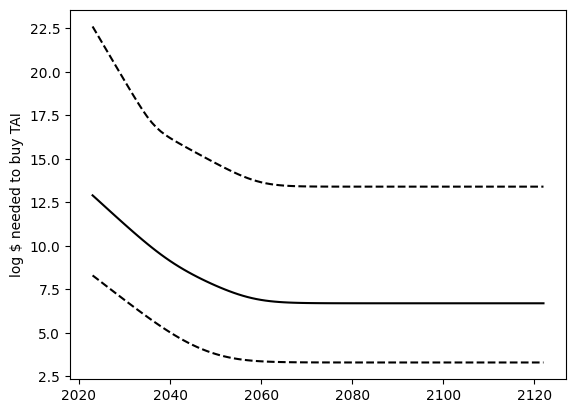

Year: 2023 - 12.9 log 2022$USD to buy TAI (~8 trillion) 90% CI 8.3 (~200 million) - 22.6 (~40 sextillion)
Year: 2024 - 12.7 log 2022$USD to buy TAI (~5 trillion) 90% CI 8.1 (~126 million) - 22.2 (~14 sextillion)
Year: 2025 - 12.4 log 2022$USD to buy TAI (~3 trillion) 90% CI 7.9 (~79 million) - 21.7 (~5 sextillion)
Year: 2026 - 12.2 log 2022$USD to buy TAI (~2 trillion) 90% CI 7.7 (~50 million) - 21.3 (~2 sextillion)
Year: 2027 - 11.9 log 2022$USD to buy TAI (~891 billion) 90% CI 7.5 (~31 million) - 20.8 (~666 quintillion)
Year: 2028 - 11.7 log 2022$USD to buy TAI (~516 billion) 90% CI 7.3 (~20 million) - 20.4 (~240 quintillion)
Year: 2029 - 11.5 log 2022$USD to buy TAI (~300 billion) 90% CI 7.1 (~12 million) - 19.9 (~86 quintillion)
Year: 2030 - 11.2 log 2022$USD to buy TAI (~175 billion) 90% CI 6.9 (~8 million) - 19.5 (~31 quintillion)
Year: 2031 - 11.0 log 2022$USD to buy TAI (~103 billion) 90% CI 6.7 (~5 million) - 19.1 (~11 quintillion)
Year: 2032 - 10.8 log 2022$USD to buy TAI (~6

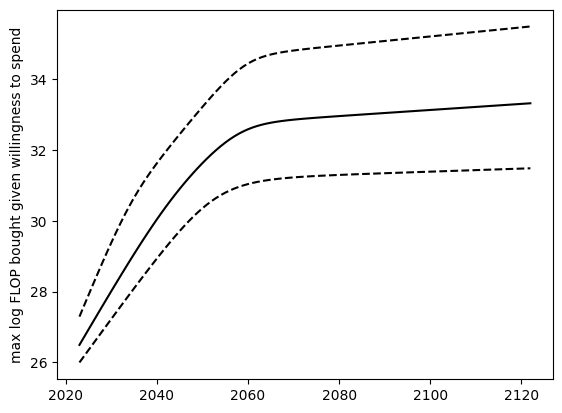

Year: 2023 - max log FLOP 26.5 (~311 septillion) 90% CI 26.0 (~99 septillion) - 27.3 (~2 octillion)
Year: 2024 - max log FLOP 26.7 (~515 septillion) 90% CI 26.2 (~149 septillion) - 27.6 (~4 octillion)
Year: 2025 - max log FLOP 26.9 (~852 septillion) 90% CI 26.3 (~223 septillion) - 27.9 (~8 octillion)
Year: 2026 - max log FLOP 27.1 (~1 octillion) 90% CI 26.5 (~335 septillion) - 28.2 (~16 octillion)
Year: 2027 - max log FLOP 27.4 (~2 octillion) 90% CI 26.7 (~502 septillion) - 28.5 (~32 octillion)
Year: 2028 - max log FLOP 27.6 (~4 octillion) 90% CI 26.9 (~752 septillion) - 28.8 (~64 octillion)
Year: 2029 - max log FLOP 27.8 (~6 octillion) 90% CI 27.1 (~1 octillion) - 29.1 (~126 octillion)
Year: 2030 - max log FLOP 28.0 (~10 octillion) 90% CI 27.2 (~2 octillion) - 29.4 (~243 octillion)
Year: 2031 - max log FLOP 28.2 (~17 octillion) 90% CI 27.4 (~3 octillion) - 29.7 (~461 octillion)
Year: 2032 - max log FLOP 28.4 (~28 octillion) 90% CI 27.6 (~4 octillion) - 29.9 (~853 octillion)
Year: 2033

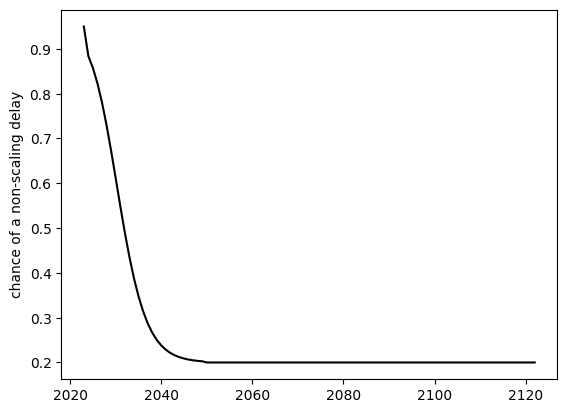

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 88%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 86%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 82%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 78%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 73%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 67%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 61%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 55%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 49%
Year: 2033

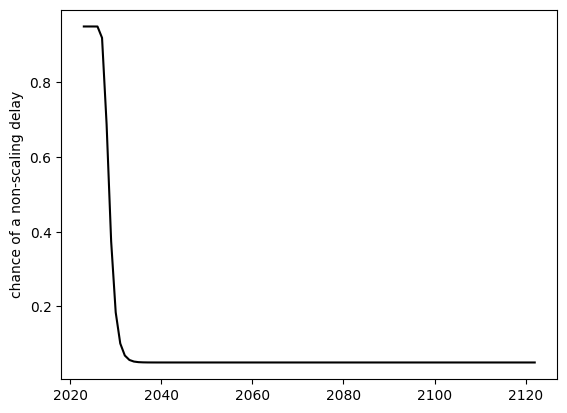

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 95%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 92%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 69%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 37%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 7%
Year: 2033 

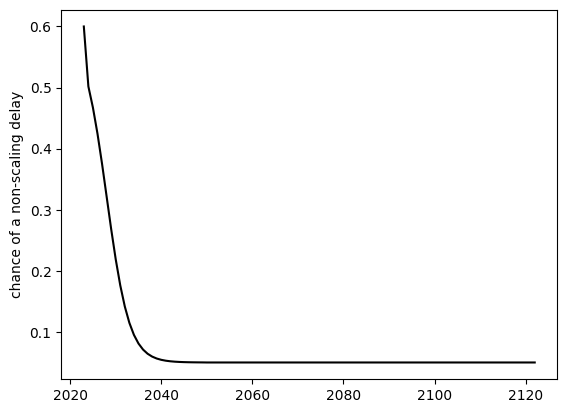

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 60%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 50%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 47%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 42%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 38%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 32%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 27%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 22%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 14%
Year: 2033

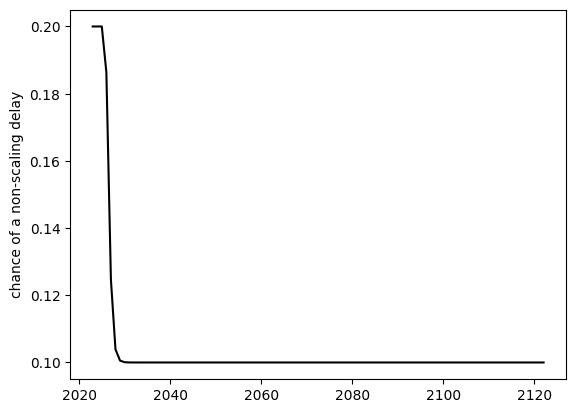

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 20%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 19%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

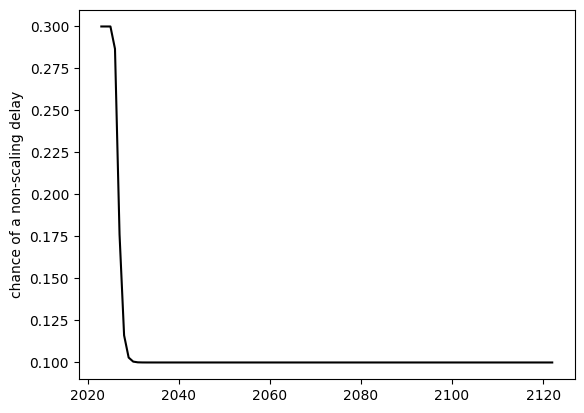

Year: 2023 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2024 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2025 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 30%
Year: 2026 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 29%
Year: 2027 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 18%
Year: 2028 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 12%
Year: 2029 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2030 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2031 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2032 - chance of a nonscaling delay if TAI compute needs are otherwise met in this year: 10%
Year: 2033

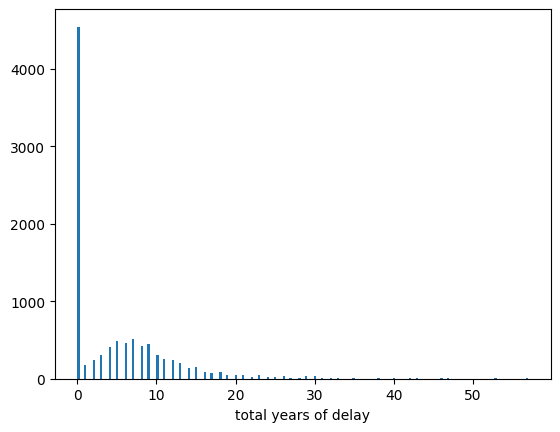

In [9]:
variables['RUNS'] = RUNS
variables['CURRENT_YEAR'] = CURRENT_YEAR
variables['MAX_YEAR'] = MAX_YEAR

run_timelines_model(variables,
                    cores=5,
                    runs=variables['RUNS'],
                    #dump_cache_file='caches/tai_years_metaculus_parity')
                    dump_cache_file='caches/tai_years')


-
-
## SAMPLE RUN 4 ##
It takes 40.9 log FLOP (~79 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.0 years to a max of 0.184486% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.0 max log FLOP (100 septillion) available - TAI takes 40.9 log FLOP (79 million decillion) - log $ 22.6 to buy TAI (40 sextillion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (160 septillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 22.2 to buy TAI (16 sextillion) vs. willingness to pay log $ 7.8 (63 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLO

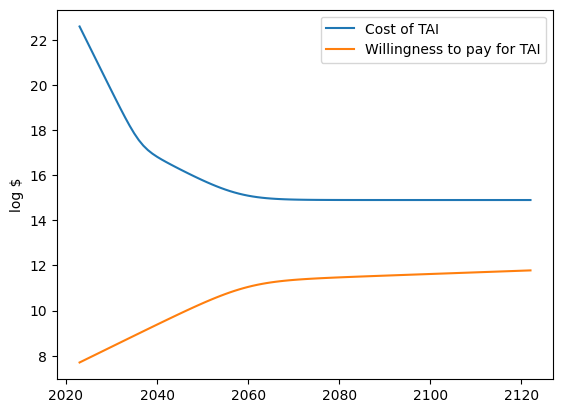

-
-
## SAMPLE RUN 5 ##
It takes 32.6 log FLOP (~398 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 24.4 log FLOP (~3 septillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 1.6 years to a max of 0.062122% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.1 max log FLOP (125 septillion) available - TAI takes 32.6 log FLOP (398 nonillion) - log $ 14.3 to buy TAI (200 trillion) vs. willingness to pay log $ 7.8 (63 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (252 septillion) available - TAI takes 32.5 log FLOP (285 nonillion) - log $ 14.0 to buy TAI (108 trillion) vs. willingness to pay log $ 8.0 (95 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (509 septillion) ava

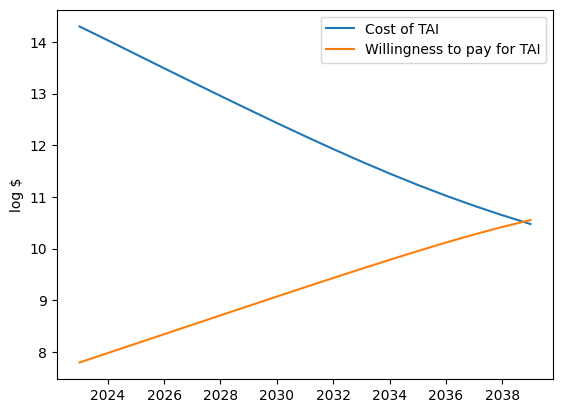

-
-
## SAMPLE RUN 6 ##
It takes 36.8 log FLOP (~6 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~17 sextillion) per 2022$USD.
We are initially willing to pay 9.5 log 2022$USD (~3 billion). This doubles every 3.0 years to a max of 0.051387% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 27.7 max log FLOP (5 octillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.5 to buy TAI (3 quintillion) vs. willingness to pay log $ 9.4 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.9 max log FLOP (8 octillion) available - TAI takes 36.5 log FLOP (3 thousand decillion) - log $ 18.1 to buy TAI (1 quintillion) vs. willingness to pay log $ 9.5 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.1 max log FLOP (12 o

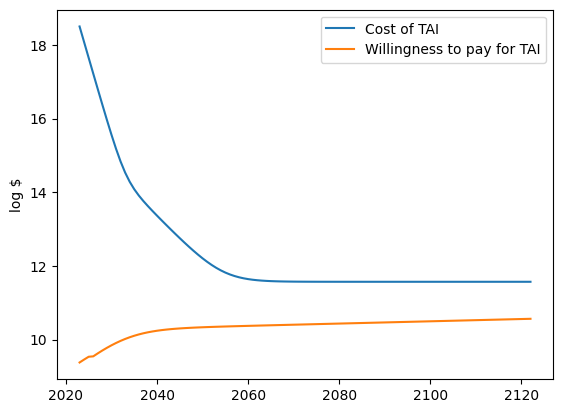

-
-
## SAMPLE RUN 7 ##
It takes 28.3 log FLOP (~20 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.3 log FLOP (~19 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~158 million). This doubles every 2.7 years to a max of 0.135063% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.5 max log FLOP (313 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 10.0 to buy TAI (10 billion) vs. willingness to pay log $ 8.2 (157 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (554 septillion) available - TAI takes 28.2 log FLOP (16 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.3 (202 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (981 septillion) available

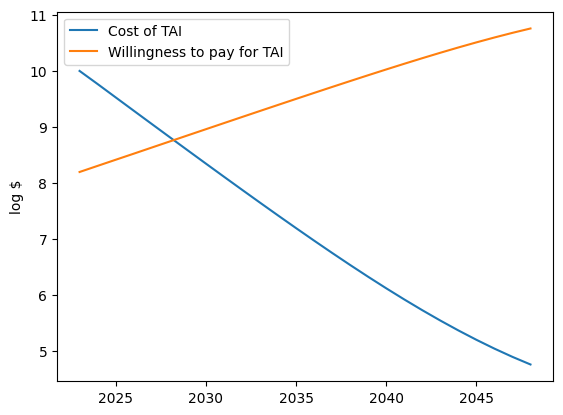

-
-
## SAMPLE RUN 8 ##
It takes 27.3 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~125 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~250 million). This doubles every 4.7 years to a max of 0.180915% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.7 max log FLOP (495 septillion) available - TAI takes 27.3 log FLOP (2 octillion) - log $ 9.0 to buy TAI (1 billion) vs. willingness to pay log $ 8.4 (248 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (761 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.8 to buy TAI (605 million) vs. willingness to pay log $ 8.5 (287 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) available - TAI

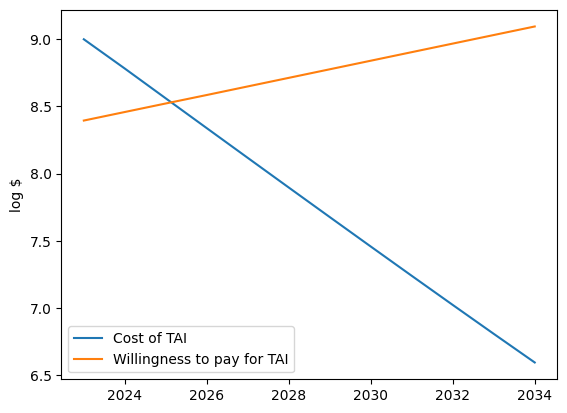

-
-
## SAMPLE RUN 9 ##
It takes 35.8 log FLOP (~631 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~85 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~627 million). This doubles every 3.9 years to a max of 0.486096% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 27.1 max log FLOP (1 octillion) available - TAI takes 35.8 log FLOP (631 decillion) - log $ 17.5 to buy TAI (316 quadrillion) vs. willingness to pay log $ 8.8 (624 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.2 to buy TAI (145 quadrillion) vs. willingness to pay log $ 8.9 (745 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) av

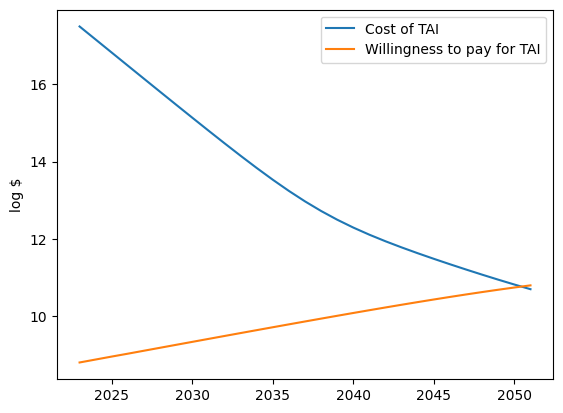

-
-
## SAMPLE RUN 10 ##
It takes 44.0 log FLOP (~100 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.5 log FLOP (~33 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~124 million). This doubles every 2.4 years to a max of 0.033245% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.4 max log FLOP (243 septillion) available - TAI takes 44.0 log FLOP (100 billion decillion) - log $ 25.7 to buy TAI (50 septillion) vs. willingness to pay log $ 8.1 (122 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (423 septillion) available - TAI takes 43.7 log FLOP (50 billion decillion) - log $ 25.3 to buy TAI (19 septillion) vs. willingness to pay log $ 8.2 (163 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max l

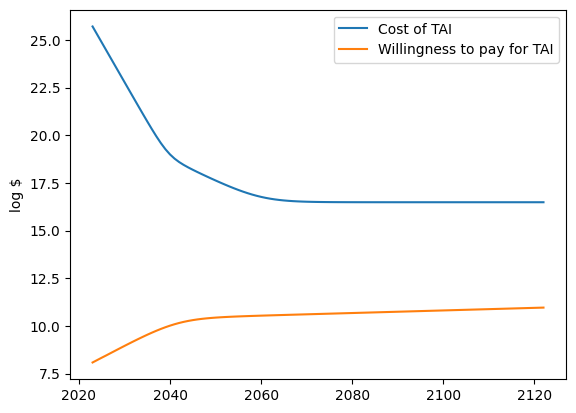

-
-
## SAMPLE RUN 11 ##
It takes 43.1 log FLOP (~13 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~39 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~300 million). This doubles every 2.8 years to a max of 0.025% of GDP. GDP grows at a rate of 1.016x per year.
---
Year: 2023 - 26.8 max log FLOP (568 septillion) available - TAI takes 43.1 log FLOP (13 billion decillion) - log $ 24.8 to buy TAI (6 septillion) vs. willingness to pay log $ 8.5 (285 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (915 septillion) available - TAI takes 42.8 log FLOP (6 billion decillion) - log $ 24.4 to buy TAI (2 septillion) vs. willingness to pay log $ 8.6 (361 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP 

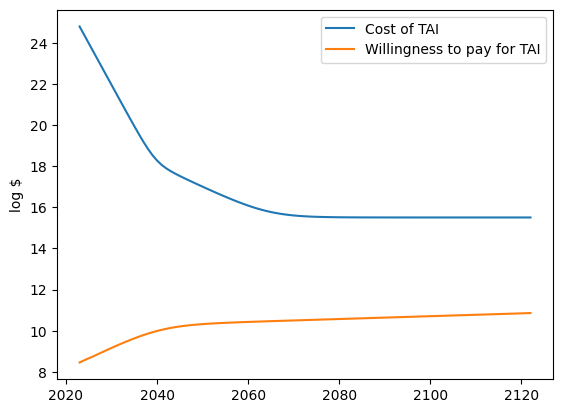

-
-
## SAMPLE RUN 12 ##
It takes 39.7 log FLOP (~5 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 24.3 log FLOP (~2 septillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~99 million). This doubles every 3.2 years to a max of 0.058835% of GDP. GDP grows at a rate of 1.018x per year.
---
Year: 2023 - 26.3 max log FLOP (197 septillion) available - TAI takes 39.7 log FLOP (5 million decillion) - log $ 21.4 to buy TAI (3 sextillion) vs. willingness to pay log $ 8.0 (99 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (317 septillion) available - TAI takes 39.4 log FLOP (3 million decillion) - log $ 21.0 to buy TAI (965 quintillion) vs. willingness to pay log $ 8.1 (122 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP

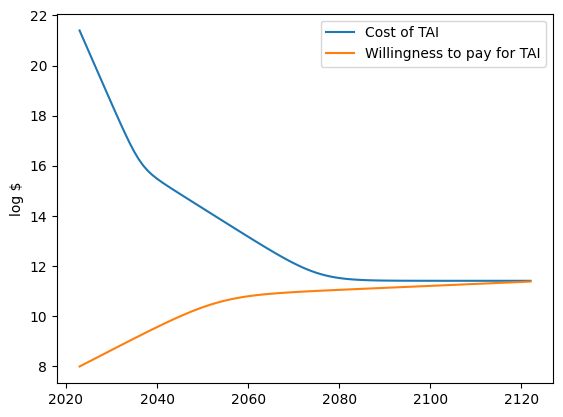

-
-
## SAMPLE RUN 13 ##
It takes 31.5 log FLOP (~32 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.3 log FLOP (~218 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 31.5 log FLOP (32 nonillion) - log $ 13.2 to buy TAI (16 trillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (490 septillion) available - TAI takes 31.4 log FLOP (24 nonillion) - log $ 13.0 to buy TAI (9 trillion) vs. willingness to pay log $ 8.3 (188 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (799 septillion) availa

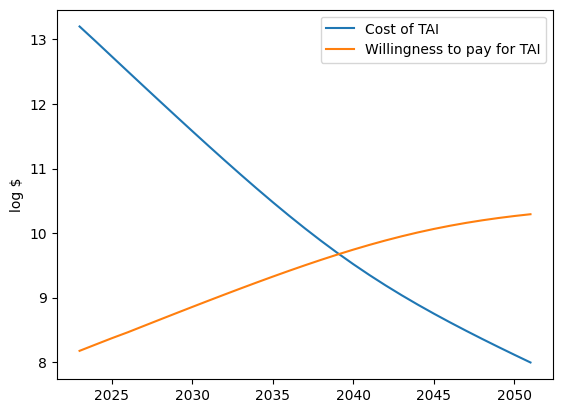

-
-
## SAMPLE RUN 14 ##
It takes 47.0 log FLOP (~100 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.1 log FLOP (~125 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.0 max log FLOP (98 septillion) available - TAI takes 47.0 log FLOP (100 trillion decillion) - log $ 28.7 to buy TAI (50 octillion) vs. willingness to pay log $ 7.7 (49 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (160 septillion) available - TAI takes 46.7 log FLOP (50 trillion decillion) - log $ 28.3 to buy TAI (19 octillion) vs. willingness to pay log $ 7.8 (61 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FL

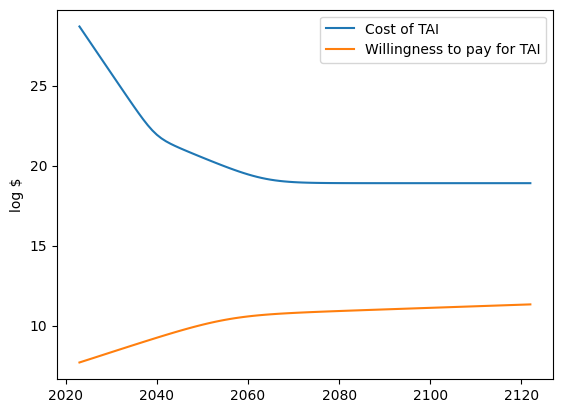

-
-
## SAMPLE RUN 15 ##
It takes 44.3 log FLOP (~200 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~589 million). This doubles every 2.1 years to a max of 0.038117% of GDP. GDP grows at a rate of 1.011x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 44.3 log FLOP (200 billion decillion) - log $ 26.0 to buy TAI (100 septillion) vs. willingness to pay log $ 8.7 (552 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.3 max log FLOP (2 octillion) available - TAI takes 44.0 log FLOP (100 billion decillion) - log $ 25.6 to buy TAI (37 septillion) vs. willingness to pay log $ 8.9 (750 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.6 max log F

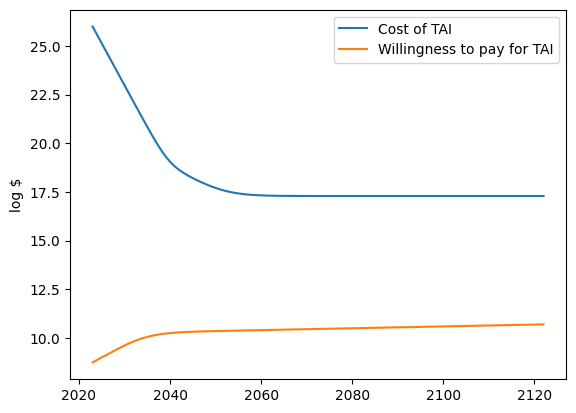

-
-
## SAMPLE RUN 16 ##
It takes 31.3 log FLOP (~20 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~24 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~157 million). This doubles every 3.0 years to a max of 0.077798% of GDP. GDP grows at a rate of 1.021x per year.
---
Year: 2023 - 26.5 max log FLOP (311 septillion) available - TAI takes 31.3 log FLOP (20 nonillion) - log $ 13.0 to buy TAI (10 trillion) vs. willingness to pay log $ 8.2 (156 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (525 septillion) available - TAI takes 31.2 log FLOP (15 nonillion) - log $ 12.8 to buy TAI (6 trillion) vs. willingness to pay log $ 8.3 (196 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (887 septillion) avai

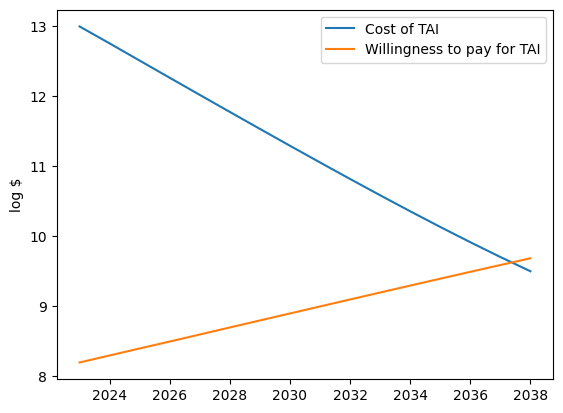

-
-
## SAMPLE RUN 17 ##
It takes 40.4 log FLOP (~25 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~620 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 2.9 years to a max of 0.040499% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 26.6 max log FLOP (382 septillion) available - TAI takes 40.4 log FLOP (25 million decillion) - log $ 22.1 to buy TAI (13 sextillion) vs. willingness to pay log $ 8.3 (191 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (629 septillion) available - TAI takes 40.1 log FLOP (13 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 8.4 (242 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log

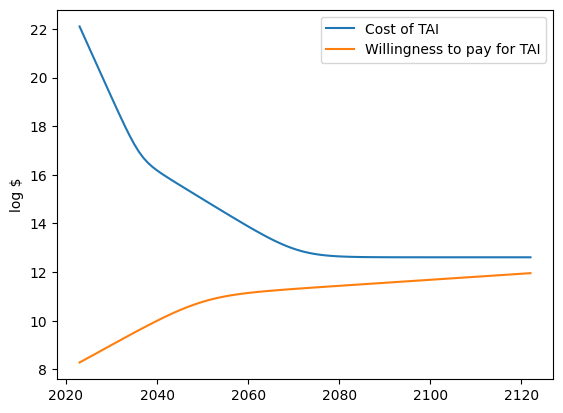

-
-
## SAMPLE RUN 18 ##
It takes 28.9 log FLOP (~79 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~94 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~31 million). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 25.8 max log FLOP (62 septillion) available - TAI takes 28.9 log FLOP (79 octillion) - log $ 10.6 to buy TAI (40 billion) vs. willingness to pay log $ 7.5 (31 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (103 septillion) available - TAI takes 28.8 log FLOP (64 octillion) - log $ 10.4 to buy TAI (25 billion) vs. willingness to pay log $ 7.6 (40 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.2 max log FLOP (168 septillion) available - 

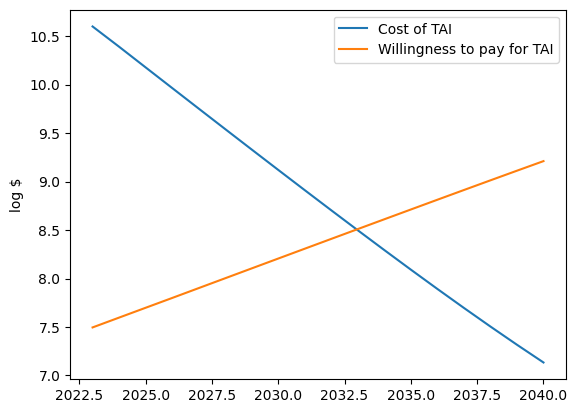

-
-
## SAMPLE RUN 19 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~49 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 2.7 years to a max of 0.086293% of GDP. GDP grows at a rate of 1.008x per year.
---
Year: 2023 - 26.4 max log FLOP (248 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.4 to buy TAI (3 trillion) vs. willingness to pay log $ 8.1 (124 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (410 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.2 to buy TAI (1 trillion) vs. willingness to pay log $ 8.2 (160 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (678 septillion) availabl

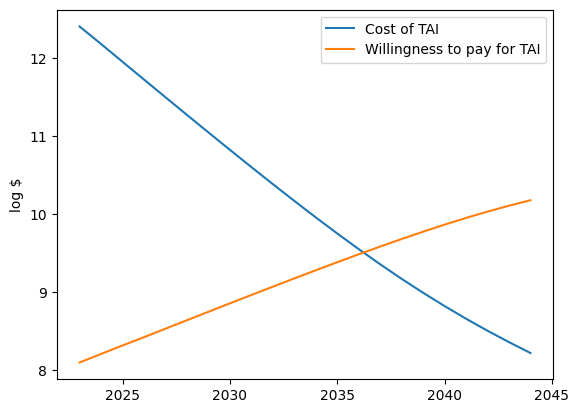

-
-
## SAMPLE RUN 20 ##
It takes 29.1 log FLOP (~126 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.9 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.005x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 29.1 log FLOP (126 octillion) - log $ 10.8 to buy TAI (63 billion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (538 septillion) available - TAI takes 29.0 log FLOP (101 octillion) - log $ 10.6 to buy TAI (37 billion) vs. willingness to pay log $ 8.3 (196 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (963 septillion) availa

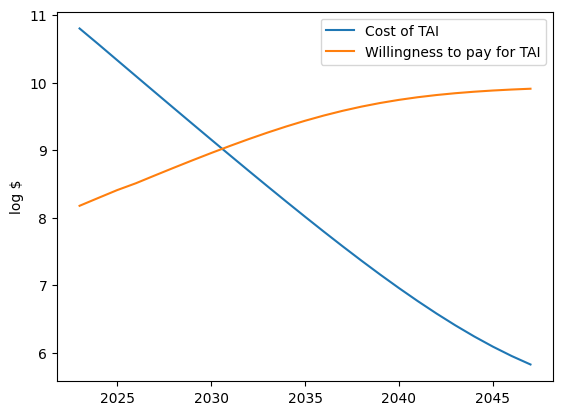

-
-
## SAMPLE RUN 21 ##
It takes 37.1 log FLOP (~13 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~63 million). This doubles every 4.1 years to a max of 0.036001% of GDP. GDP grows at a rate of 1.036x per year.
---
Year: 2023 - 26.1 max log FLOP (124 septillion) available - TAI takes 37.1 log FLOP (13 thousand decillion) - log $ 18.8 to buy TAI (6 quintillion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (195 septillion) available - TAI takes 36.8 log FLOP (6 thousand decillion) - log $ 18.4 to buy TAI (2 quintillion) vs. willingness to pay log $ 7.9 (73 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log

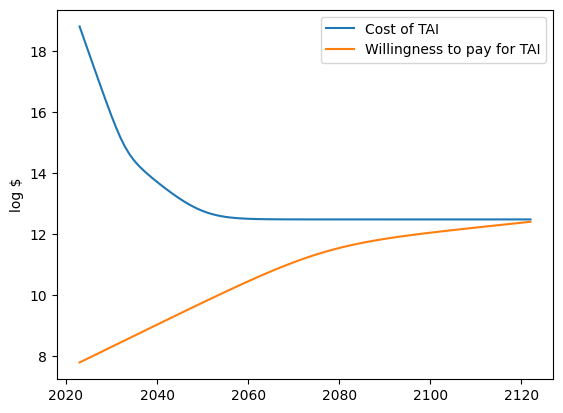

-
-
## SAMPLE RUN 22 ##
It takes 28.1 log FLOP (~13 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~582 sextillion) per 2022$USD.
We are initially willing to pay 8.7 log 2022$USD (~480 million). This doubles every 2.8 years to a max of 0.049602% of GDP. GDP grows at a rate of 1.029x per year.
---
Year: 2023 - 27.0 max log FLOP (919 septillion) available - TAI takes 28.1 log FLOP (13 octillion) - log $ 9.8 to buy TAI (6 billion) vs. willingness to pay log $ 8.7 (461 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.6 to buy TAI (4 billion) vs. willingness to pay log $ 8.8 (582 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (3 octillion) available - TA

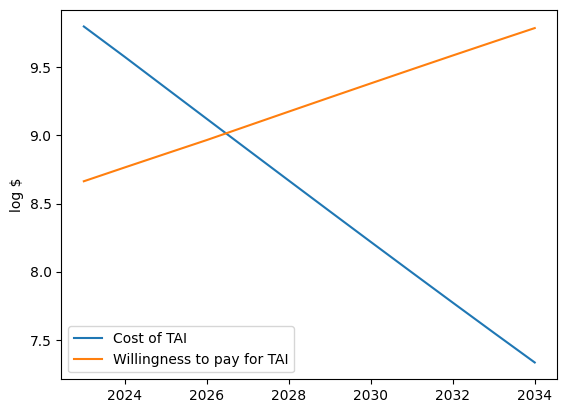

-
-
## SAMPLE RUN 23 ##
It takes 35.6 log FLOP (~398 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.4 log FLOP (~25 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~79 million). This doubles every 2.3 years to a max of 0.618256% of GDP. GDP grows at a rate of 1.034x per year.
---
Year: 2023 - 26.2 max log FLOP (158 septillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.3 to buy TAI (200 quadrillion) vs. willingness to pay log $ 7.9 (79 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (282 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.0 to buy TAI (96 quadrillion) vs. willingness to pay log $ 8.0 (108 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.7 max log FLOP (504 septill

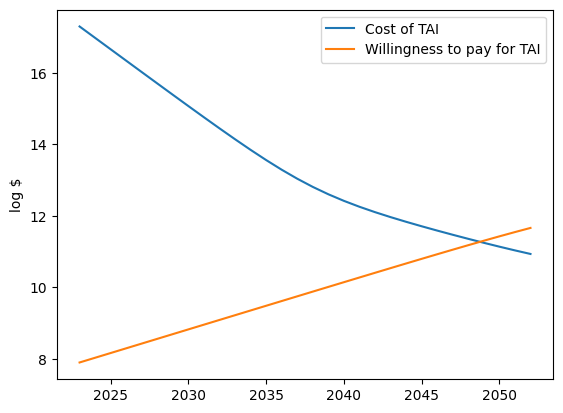

-
-
## SAMPLE RUN 24 ##
It takes 29.3 log FLOP (~200 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.7 log FLOP (~5 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~193 million). This doubles every 3.4 years to a max of 0.025% of GDP. GDP grows at a rate of 1.019x per year.
---
Year: 2023 - 26.6 max log FLOP (372 septillion) available - TAI takes 29.3 log FLOP (200 octillion) - log $ 11.0 to buy TAI (100 billion) vs. willingness to pay log $ 8.3 (187 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (595 septillion) available - TAI takes 29.2 log FLOP (160 octillion) - log $ 10.8 to buy TAI (61 billion) vs. willingness to pay log $ 8.4 (227 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (950 septillion) avail

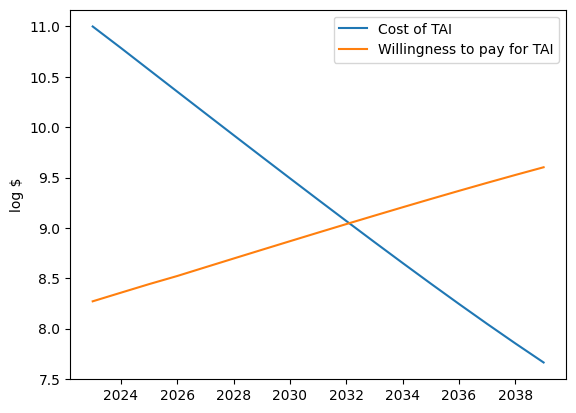

-
-
## SAMPLE RUN 25 ##
It takes 33.9 log FLOP (~8 decillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~45 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~126 million). This doubles every 3.0 years to a max of 0.272457% of GDP. GDP grows at a rate of 1.017x per year.
---
Year: 2023 - 26.4 max log FLOP (250 septillion) available - TAI takes 33.9 log FLOP (8 decillion) - log $ 15.6 to buy TAI (4 quadrillion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (431 septillion) available - TAI takes 33.8 log FLOP (6 decillion) - log $ 15.3 to buy TAI (2 quadrillion) vs. willingness to pay log $ 8.2 (158 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLOP (743 septillion) av

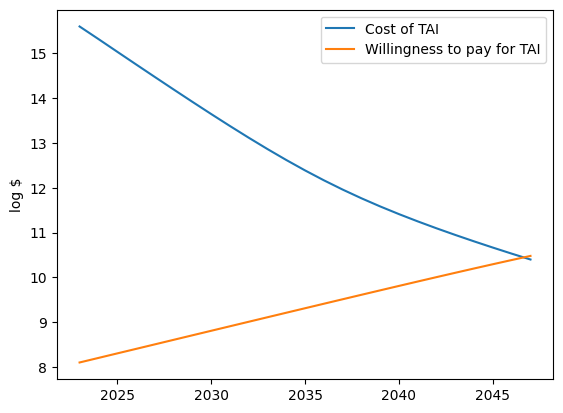

-
-
## SAMPLE RUN 26 ##
It takes 47.1 log FLOP (~126 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~325 sextillion) per 2022$USD.
We are initially willing to pay 9.1 log 2022$USD (~1 billion). This doubles every 3.0 years to a max of 0.025% of GDP. GDP grows at a rate of 1.013x per year.
---
Year: 2023 - 27.3 max log FLOP (2 octillion) available - TAI takes 47.1 log FLOP (126 trillion decillion) - log $ 28.8 to buy TAI (63 octillion) vs. willingness to pay log $ 9.0 (1 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.5 max log FLOP (3 octillion) available - TAI takes 46.8 log FLOP (63 trillion decillion) - log $ 28.4 to buy TAI (23 octillion) vs. willingness to pay log $ 9.1 (1 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.8 max log FLOP (6 oc

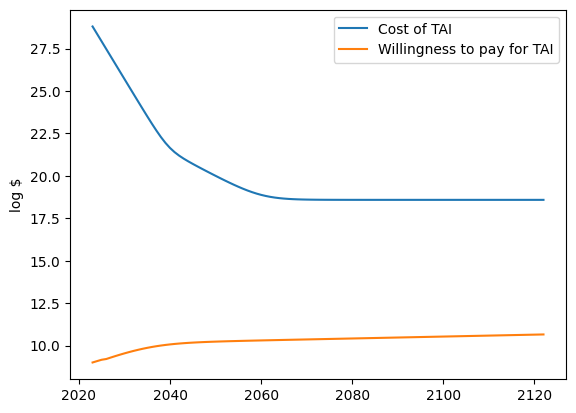

-
-
## SAMPLE RUN 27 ##
It takes 45.3 log FLOP (~2 trillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 23.9 log FLOP (~796 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 3.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 45.3 log FLOP (2 trillion decillion) - log $ 27.0 to buy TAI (1 octillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (400 septillion) available - TAI takes 45.0 log FLOP (998 billion decillion) - log $ 26.6 to buy TAI (363 septillion) vs. willingness to pay log $ 8.2 (145 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log F

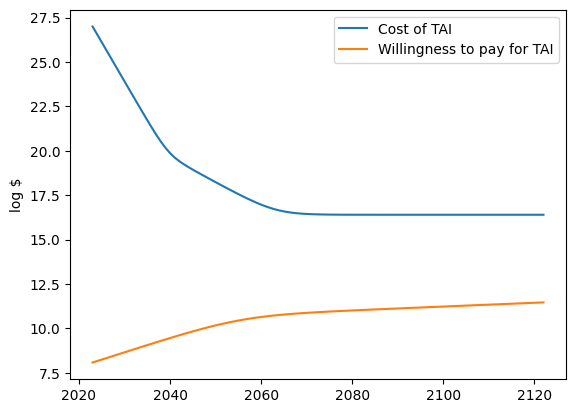

-
-
## SAMPLE RUN 28 ##
It takes 42.7 log FLOP (~5 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.4 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~125 million). This doubles every 3.1 years to a max of 0.105722% of GDP. GDP grows at a rate of 1.014x per year.
---
Year: 2023 - 26.4 max log FLOP (248 septillion) available - TAI takes 42.7 log FLOP (5 billion decillion) - log $ 24.4 to buy TAI (3 septillion) vs. willingness to pay log $ 8.1 (125 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.6 max log FLOP (405 septillion) available - TAI takes 42.4 log FLOP (3 billion decillion) - log $ 24.0 to buy TAI (961 sextillion) vs. willingness to pay log $ 8.2 (155 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLO

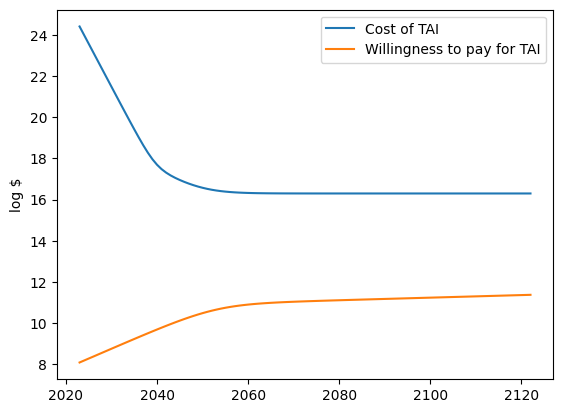

-
-
## SAMPLE RUN 29 ##
It takes 28.4 log FLOP (~25 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.6 years to a max of 0.040465% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.0 max log FLOP (99 septillion) available - TAI takes 28.4 log FLOP (25 octillion) - log $ 10.1 to buy TAI (13 billion) vs. willingness to pay log $ 7.7 (50 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (166 septillion) available - TAI takes 28.3 log FLOP (20 octillion) - log $ 9.9 to buy TAI (7 billion) vs. willingness to pay log $ 7.8 (60 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (278 septillion) available - 

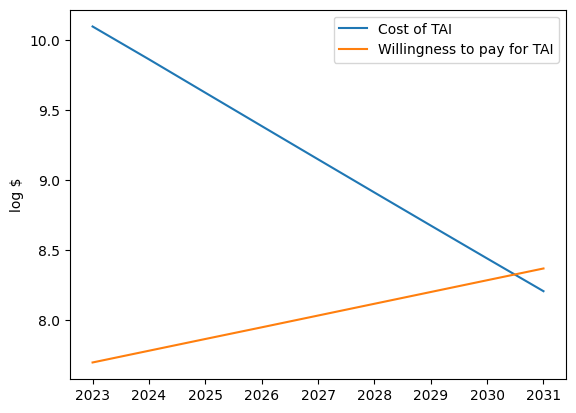

-
-
## SAMPLE RUN 30 ##
It takes 35.6 log FLOP (~398 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~58 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 3.9 years to a max of 0.0251% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 35.6 log FLOP (398 decillion) - log $ 17.3 to buy TAI (200 quadrillion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (240 septillion) available - TAI takes 35.4 log FLOP (251 decillion) - log $ 17.0 to buy TAI (97 quadrillion) vs. willingness to pay log $ 8.0 (92 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (373 septillion

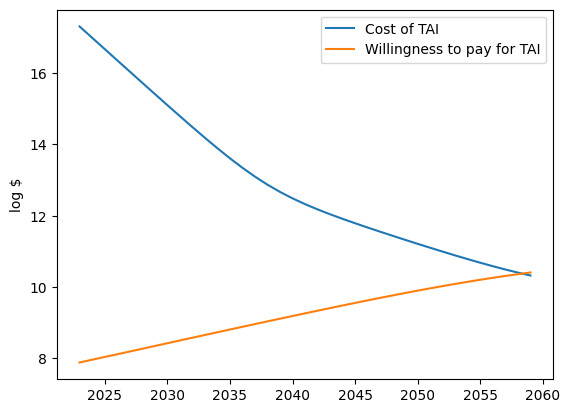

-
-
## SAMPLE RUN 31 ##
It takes 34.4 log FLOP (~25 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.5 log FLOP (~3 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~199 million). This doubles every 4.0 years to a max of 0.229717% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (395 septillion) available - TAI takes 34.4 log FLOP (25 decillion) - log $ 16.1 to buy TAI (13 quadrillion) vs. willingness to pay log $ 8.3 (198 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (618 septillion) available - TAI takes 34.2 log FLOP (16 decillion) - log $ 15.8 to buy TAI (6 quadrillion) vs. willingness to pay log $ 8.4 (235 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (968 septillion)

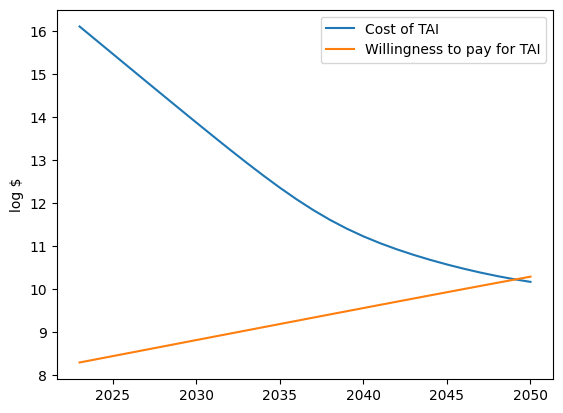

-
-
## SAMPLE RUN 32 ##
It takes 30.7 log FLOP (~5 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~6 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 2.5 years to a max of 0.025% of GDP. GDP grows at a rate of 1.032x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 30.7 log FLOP (5 nonillion) - log $ 12.4 to buy TAI (3 trillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.5 max log FLOP (347 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.2 to buy TAI (1 trillion) vs. willingness to pay log $ 8.1 (128 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.8 max log FLOP (623 septillion) available - TA

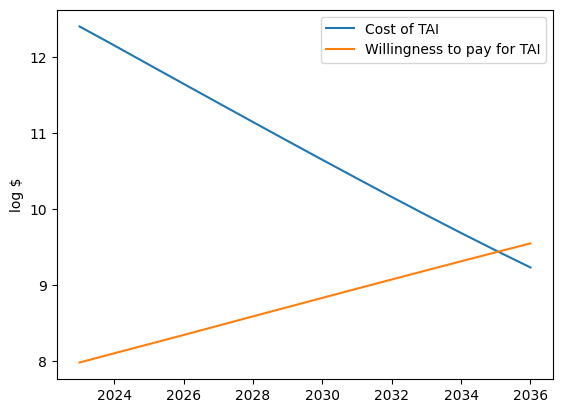

-
-
## SAMPLE RUN 33 ##
It takes 34.8 log FLOP (~63 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~90 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.007x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 34.8 log FLOP (63 decillion) - log $ 16.5 to buy TAI (32 quadrillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (514 septillion) available - TAI takes 34.6 log FLOP (40 decillion) - log $ 16.2 to buy TAI (14 quadrillion) vs. willingness to pay log $ 8.3 (186 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (1 octillion) ava

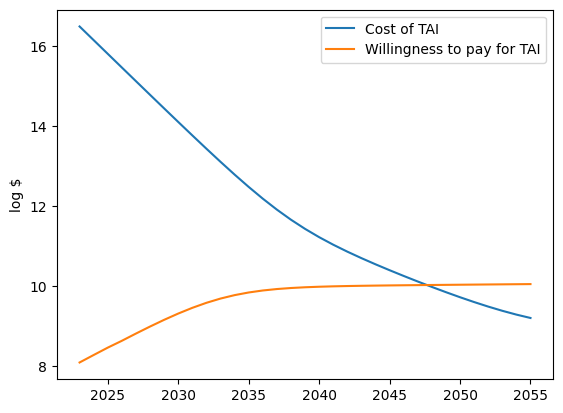

-
-
## SAMPLE RUN 34 ##
It takes 32.8 log FLOP (~631 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 3.2 years they get 2x cheaper, to a maximum of 22.1 log FLOP (~13 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~383 million). This doubles every 3.1 years to a max of 0.042821% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.9 max log FLOP (735 septillion) available - TAI takes 32.8 log FLOP (631 nonillion) - log $ 14.5 to buy TAI (316 trillion) vs. willingness to pay log $ 8.6 (368 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 32.7 log FLOP (452 nonillion) - log $ 14.3 to buy TAI (183 trillion) vs. willingness to pay log $ 8.7 (458 million) - 18.4 log FLOP per $ (2 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) avai

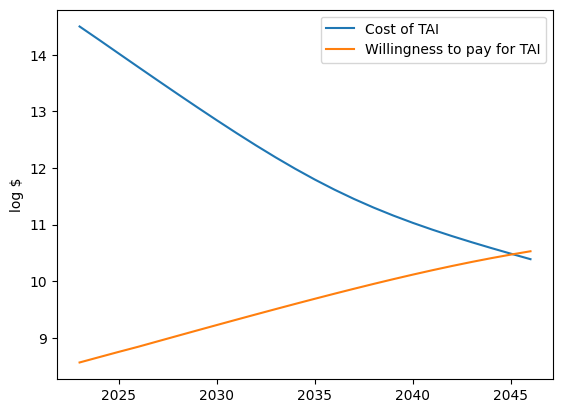

-
-
## SAMPLE RUN 35 ##
It takes 35.3 log FLOP (~200 decillion) for transformative capabilities.
Every 1.5 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.8 log FLOP (~640 sextillion) per 2022$USD.
We are initially willing to pay 8.1 log 2022$USD (~123 million). This doubles every 1.6 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.4 max log FLOP (241 septillion) available - TAI takes 35.3 log FLOP (200 decillion) - log $ 17.0 to buy TAI (100 quadrillion) vs. willingness to pay log $ 8.1 (121 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (486 septillion) available - TAI takes 35.1 log FLOP (126 decillion) - log $ 16.7 to buy TAI (48 quadrillion) vs. willingness to pay log $ 8.3 (183 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log FLOP (977 septill

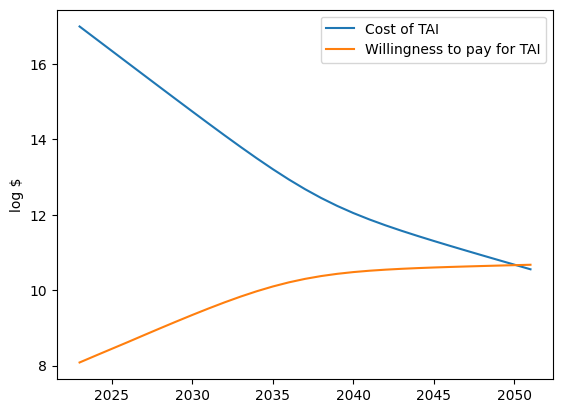

-
-
## SAMPLE RUN 36 ##
It takes 36.7 log FLOP (~5 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.1 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 9.3 log 2022$USD (~2 billion). This doubles every 1.8 years to a max of 0.390839% of GDP. GDP grows at a rate of 1.025x per year.
---
Year: 2023 - 27.6 max log FLOP (4 octillion) available - TAI takes 36.7 log FLOP (5 thousand decillion) - log $ 18.4 to buy TAI (3 quintillion) vs. willingness to pay log $ 9.3 (2 billion) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.9 max log FLOP (8 octillion) available - TAI takes 36.4 log FLOP (3 thousand decillion) - log $ 18.0 to buy TAI (905 quadrillion) vs. willingness to pay log $ 9.4 (3 billion) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 28.2 max log FLOP (16

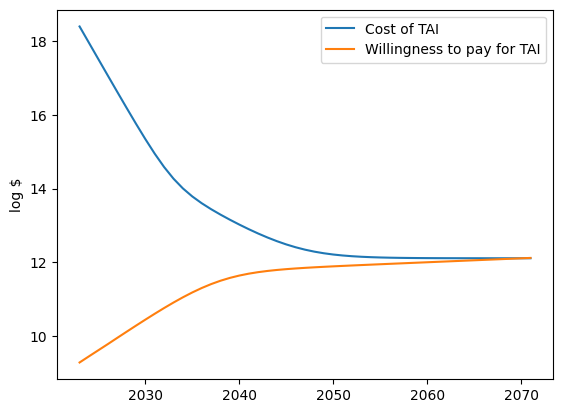

-
-
## SAMPLE RUN 37 ##
It takes 31.9 log FLOP (~79 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.2 years they get 2x cheaper, to a maximum of 21.8 log FLOP (~7 sextillion) per 2022$USD.
We are initially willing to pay 8.8 log 2022$USD (~569 million). This doubles every 4.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.031x per year.
---
Year: 2023 - 27.0 max log FLOP (1 octillion) available - TAI takes 31.9 log FLOP (79 nonillion) - log $ 13.6 to buy TAI (40 trillion) vs. willingness to pay log $ 8.7 (517 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (2 octillion) available - TAI takes 31.8 log FLOP (61 nonillion) - log $ 13.3 to buy TAI (22 trillion) vs. willingness to pay log $ 8.8 (605 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.4 max log FLOP (3 octillion) available - TAI 

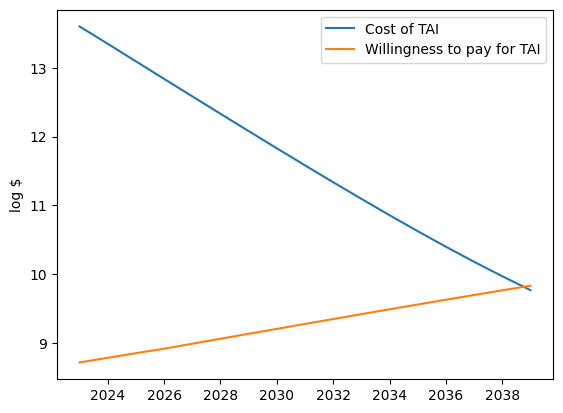

-
-
## SAMPLE RUN 38 ##
It takes 28.6 log FLOP (~40 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 23.5 log FLOP (~297 sextillion) per 2022$USD.
We are initially willing to pay 7.7 log 2022$USD (~50 million). This doubles every 3.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.0 max log FLOP (98 septillion) available - TAI takes 28.6 log FLOP (40 octillion) - log $ 10.3 to buy TAI (20 billion) vs. willingness to pay log $ 7.7 (49 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.2 max log FLOP (161 septillion) available - TAI takes 28.5 log FLOP (32 octillion) - log $ 10.1 to buy TAI (12 billion) vs. willingness to pay log $ 7.8 (61 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (264 septillion) available -

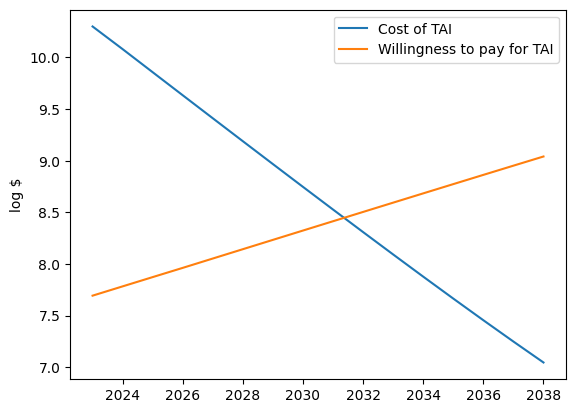

-
-
## SAMPLE RUN 39 ##
It takes 27.7 log FLOP (~5 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.2 log FLOP (~15 sextillion) per 2022$USD.
We are initially willing to pay 7.9 log 2022$USD (~78 million). This doubles every 3.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.024x per year.
---
Year: 2023 - 26.2 max log FLOP (154 septillion) available - TAI takes 27.7 log FLOP (5 octillion) - log $ 9.4 to buy TAI (3 billion) vs. willingness to pay log $ 7.9 (77 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.4 max log FLOP (251 septillion) available - TAI takes 27.6 log FLOP (4 octillion) - log $ 9.2 to buy TAI (2 billion) vs. willingness to pay log $ 8.0 (95 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.6 max log FLOP (409 septillion) available - TAI take

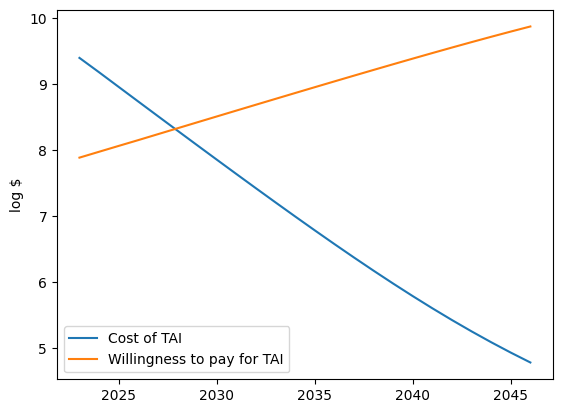

-
-
## SAMPLE RUN 40 ##
It takes 38.4 log FLOP (~251 thousand decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 4.3 years to a max of 0.025% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 38.4 log FLOP (251 thousand decillion) - log $ 20.1 to buy TAI (126 quintillion) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (710 septillion) available - TAI takes 38.1 log FLOP (126 thousand decillion) - log $ 19.7 to buy TAI (48 quintillion) vs. willingness to pay log $ 8.4 (270 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 ma

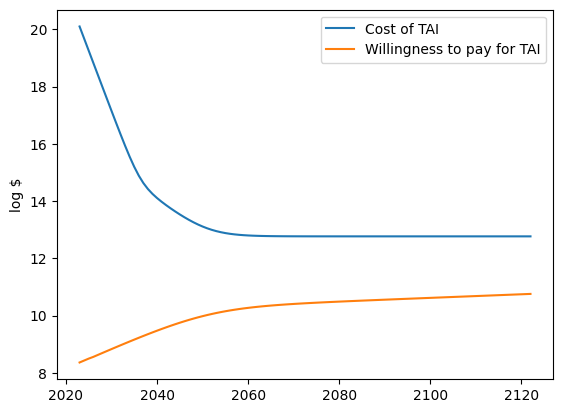

-
-
## SAMPLE RUN 41 ##
It takes 28.0 log FLOP (~10 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~43 sextillion) per 2022$USD.
We are initially willing to pay 7.6 log 2022$USD (~40 million). This doubles every 3.1 years to a max of 0.126085% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 25.9 max log FLOP (79 septillion) available - TAI takes 28.0 log FLOP (10 octillion) - log $ 9.7 to buy TAI (5 billion) vs. willingness to pay log $ 7.6 (40 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.1 max log FLOP (134 septillion) available - TAI takes 27.9 log FLOP (8 octillion) - log $ 9.5 to buy TAI (3 billion) vs. willingness to pay log $ 7.7 (49 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.4 max log FLOP (226 septillion) available - TA

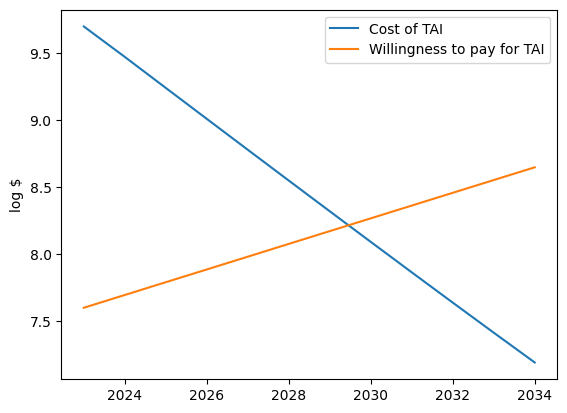

-
-
## SAMPLE RUN 42 ##
It takes 30.6 log FLOP (~4 nonillion) for transformative capabilities.
Every 2.5 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 23.0 log FLOP (~107 sextillion) per 2022$USD.
We are initially willing to pay 8.5 log 2022$USD (~313 million). This doubles every 3.8 years to a max of 0.130928% of GDP. GDP grows at a rate of 1.015x per year.
---
Year: 2023 - 26.8 max log FLOP (618 septillion) available - TAI takes 30.6 log FLOP (4 nonillion) - log $ 12.3 to buy TAI (2 trillion) vs. willingness to pay log $ 8.5 (310 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.0 max log FLOP (979 septillion) available - TAI takes 30.5 log FLOP (3 nonillion) - log $ 12.1 to buy TAI (1 trillion) vs. willingness to pay log $ 8.6 (370 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.2 max log FLOP (2 octillion) available 

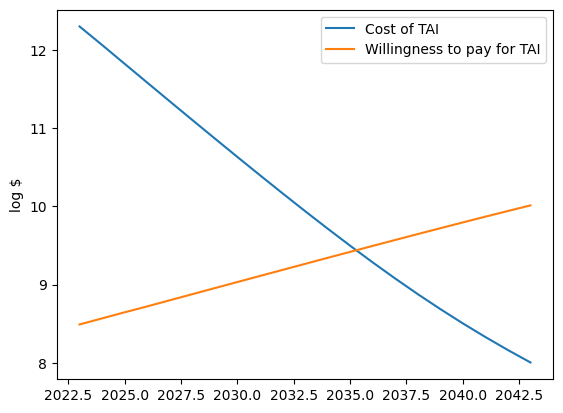

-
-
## SAMPLE RUN 43 ##
It takes 39.8 log FLOP (~6 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 24.2 log FLOP (~1 septillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~380 million). This doubles every 3.0 years to a max of 0.035514% of GDP. GDP grows at a rate of 1.026x per year.
---
Year: 2023 - 26.9 max log FLOP (724 septillion) available - TAI takes 39.8 log FLOP (6 million decillion) - log $ 21.5 to buy TAI (3 sextillion) vs. willingness to pay log $ 8.6 (363 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.1 max log FLOP (1 octillion) available - TAI takes 39.5 log FLOP (3 million decillion) - log $ 21.1 to buy TAI (1 sextillion) vs. willingness to pay log $ 8.7 (454 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.3 max log FLOP (2 

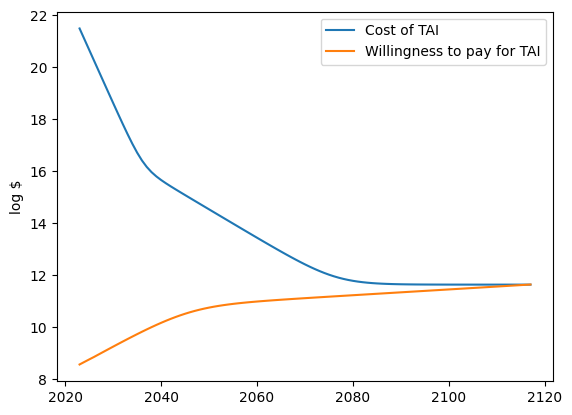

-
-
## SAMPLE RUN 44 ##
It takes 27.2 log FLOP (~2 octillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.6 years they get 2x cheaper, to a maximum of 21.6 log FLOP (~4 sextillion) per 2022$USD.
We are initially willing to pay 8.4 log 2022$USD (~241 million). This doubles every 3.2 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.7 max log FLOP (461 septillion) available - TAI takes 27.2 log FLOP (2 octillion) - log $ 8.9 to buy TAI (795 million) vs. willingness to pay log $ 8.4 (231 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.9 max log FLOP (741 septillion) available - TAI takes 27.1 log FLOP (1 octillion) - log $ 8.7 to buy TAI (489 million) vs. willingness to pay log $ 8.5 (285 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP (1 octillion) available - TAI ta

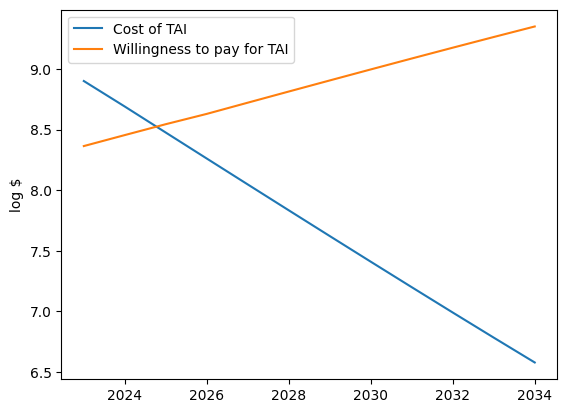

-
-
## SAMPLE RUN 45 ##
It takes 39.4 log FLOP (~3 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 22.6 log FLOP (~44 sextillion) per 2022$USD.
We are initially willing to pay 7.5 log 2022$USD (~32 million). This doubles every 2.7 years to a max of 0.063724% of GDP. GDP grows at a rate of 1.028x per year.
---
Year: 2023 - 25.8 max log FLOP (63 septillion) available - TAI takes 39.4 log FLOP (3 million decillion) - log $ 21.1 to buy TAI (1 sextillion) vs. willingness to pay log $ 7.5 (31 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.0 max log FLOP (104 septillion) available - TAI takes 39.1 log FLOP (1 million decillion) - log $ 20.7 to buy TAI (491 quintillion) vs. willingness to pay log $ 7.6 (41 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.2 max log FLOP 

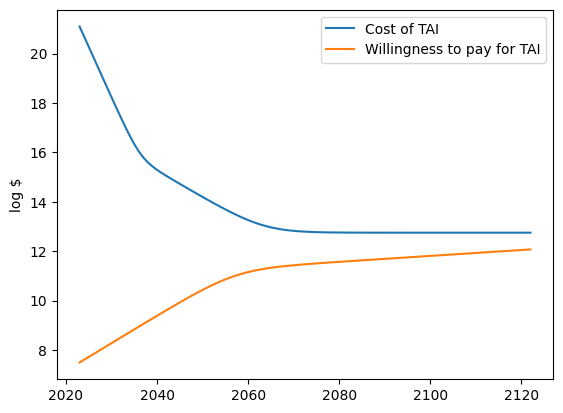

-
-
## SAMPLE RUN 46 ##
It takes 26.4 log FLOP (~251 septillion) for transformative capabilities.
Every 3 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.6 log FLOP (~428 sextillion) per 2022$USD.
We are initially willing to pay 9.2 log 2022$USD (~2 billion). This doubles every 1.6 years to a max of 0.044924% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 27.5 max log FLOP (3 octillion) available - TAI takes 26.4 log FLOP (251 septillion) - log $ 8.1 to buy TAI (126 million) vs. willingness to pay log $ 9.2 (1 billion) - 18.3 log FLOP per $ (2 quintillion)
-- algorithms p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 5 years (total delay 5 years)
-- data p_nonscaling_issue p=0.95 -> Nonscaling delay occured
-- -- this delay is 1 years (total delay 6 years)
-- robotics p_nonscaling_issue p=0.6 -> Nonscali

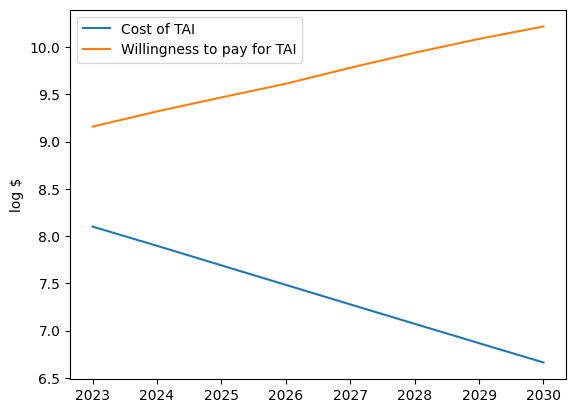

-
-
## SAMPLE RUN 47 ##
It takes 32.9 log FLOP (~794 nonillion) for transformative capabilities.
Every 2.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~142 sextillion) per 2022$USD.
We are initially willing to pay 8.6 log 2022$USD (~395 million). This doubles every 1.7 years to a max of 0.205959% of GDP. GDP grows at a rate of 1.039x per year.
---
Year: 2023 - 26.9 max log FLOP (781 septillion) available - TAI takes 32.9 log FLOP (794 nonillion) - log $ 14.6 to buy TAI (398 trillion) vs. willingness to pay log $ 8.6 (392 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 27.2 max log FLOP (1 octillion) available - TAI takes 32.8 log FLOP (570 nonillion) - log $ 14.3 to buy TAI (224 trillion) vs. willingness to pay log $ 8.8 (584 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.5 max log FLOP (3 octillion) ava

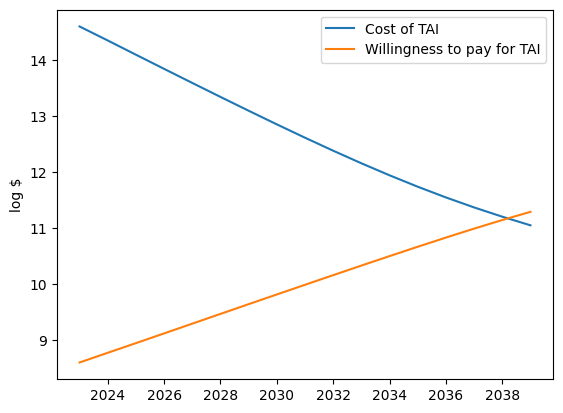

-
-
## SAMPLE RUN 48 ##
It takes 40.4 log FLOP (~25 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.5 years they get 2x cheaper, to a maximum of 22.0 log FLOP (~10 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 40.4 log FLOP (25 million decillion) - log $ 22.1 to buy TAI (13 sextillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (491 septillion) available - TAI takes 40.1 log FLOP (13 million decillion) - log $ 21.7 to buy TAI (5 sextillion) vs. willingness to pay log $ 8.3 (187 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log FLO

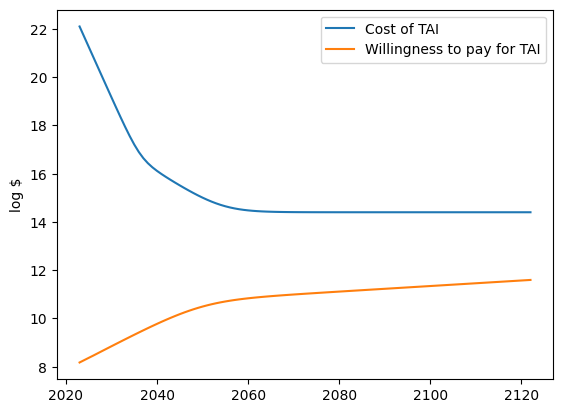

-
-
## SAMPLE RUN 49 ##
It takes 29.9 log FLOP (~794 octillion) for transformative capabilities.
Every 3.0 years algorithms get 2x better, with 2 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.4 years they get 2x cheaper, to a maximum of 22.7 log FLOP (~46 sextillion) per 2022$USD.
We are initially willing to pay 7.8 log 2022$USD (~62 million). This doubles every 3.1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.023x per year.
---
Year: 2023 - 26.1 max log FLOP (123 septillion) available - TAI takes 29.9 log FLOP (794 octillion) - log $ 11.6 to buy TAI (398 billion) vs. willingness to pay log $ 7.8 (62 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.3 max log FLOP (206 septillion) available - TAI takes 29.8 log FLOP (638 octillion) - log $ 11.4 to buy TAI (238 billion) vs. willingness to pay log $ 7.9 (77 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.5 max log FLOP (345 septillion) availa

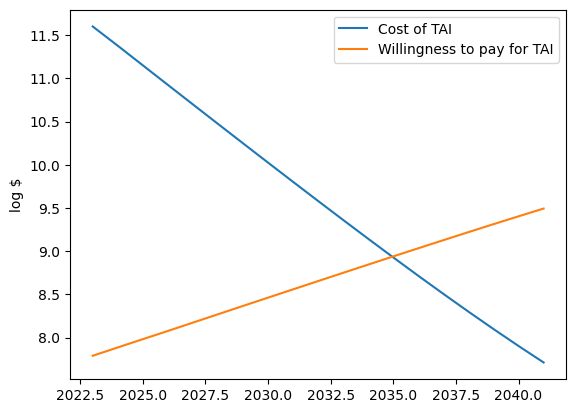

-
-
## SAMPLE RUN 50 ##
It takes 51.3 log FLOP (~2 quintillion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.9 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~66 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~194 million). This doubles every 4.0 years to a max of 0.029694% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.6 max log FLOP (376 septillion) available - TAI takes 51.3 log FLOP (2 quintillion decillion) - log $ 33.0 to buy TAI (1 decillion) vs. willingness to pay log $ 8.3 (189 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (568 septillion) available - TAI takes 51.0 log FLOP (998 quadrillion decillion) - log $ 32.6 to buy TAI (392 nonillion) vs. willingness to pay log $ 8.3 (224 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.

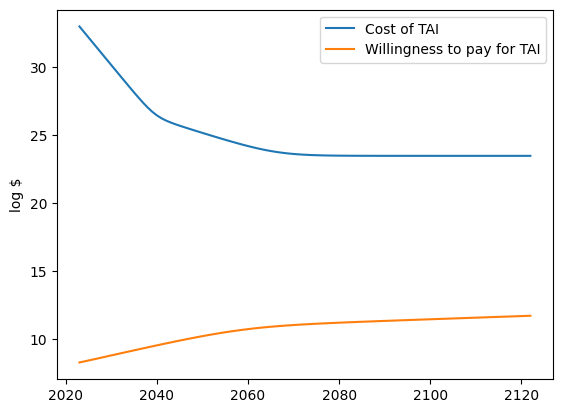

-
-
## SAMPLE RUN 51 ##
It takes 44.2 log FLOP (~158 billion decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 5 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.3 years they get 2x cheaper, to a maximum of 22.9 log FLOP (~83 sextillion) per 2022$USD.
We are initially willing to pay 8.0 log 2022$USD (~98 million). This doubles every 1 years to a max of 0.025% of GDP. GDP grows at a rate of 1.027x per year.
---
Year: 2023 - 26.3 max log FLOP (193 septillion) available - TAI takes 44.2 log FLOP (158 billion decillion) - log $ 25.9 to buy TAI (79 septillion) vs. willingness to pay log $ 8.0 (97 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (513 septillion) available - TAI takes 43.9 log FLOP (79 billion decillion) - log $ 25.5 to buy TAI (29 septillion) vs. willingness to pay log $ 8.3 (190 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.1 max log FLOP

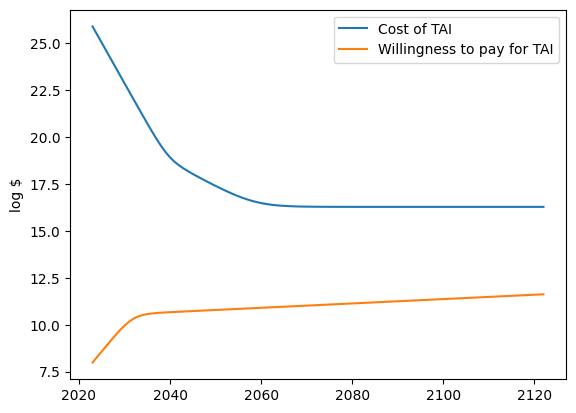

-
-
## SAMPLE RUN 52 ##
It takes 36.9 log FLOP (~8 thousand decillion) for transformative capabilities.
Every 1.0 years algorithms get 2x better, with 3 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.8 years they get 2x cheaper, to a maximum of 23.2 log FLOP (~161 sextillion) per 2022$USD.
We are initially willing to pay 8.2 log 2022$USD (~154 million). This doubles every 2.7 years to a max of 0.025% of GDP. GDP grows at a rate of 1.02x per year.
---
Year: 2023 - 26.5 max log FLOP (300 septillion) available - TAI takes 36.9 log FLOP (8 thousand decillion) - log $ 18.6 to buy TAI (4 quintillion) vs. willingness to pay log $ 8.2 (150 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.7 max log FLOP (493 septillion) available - TAI takes 36.6 log FLOP (4 thousand decillion) - log $ 18.2 to buy TAI (2 quintillion) vs. willingness to pay log $ 8.3 (193 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 26.9 max log 

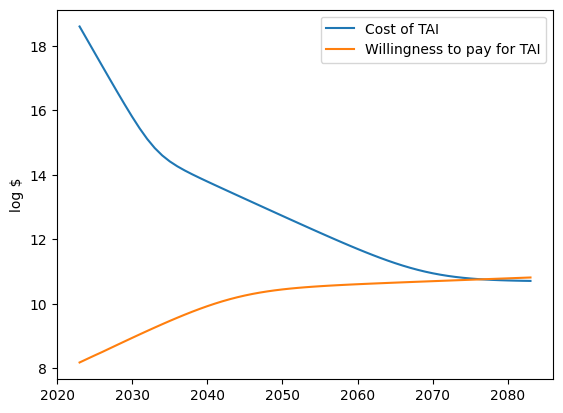

-
-
## SAMPLE RUN 53 ##
It takes 40.9 log FLOP (~79 million decillion) for transformative capabilities.
Every 1 years algorithms get 2x better, with 4 log reductions possible.
FLOP start at a cost of 18.3 log FLOP (~2 quintillion) per 2022$USD. Every 2.7 years they get 2x cheaper, to a maximum of 22.8 log FLOP (~68 sextillion) per 2022$USD.
We are initially willing to pay 8.3 log 2022$USD (~195 million). This doubles every 3.6 years to a max of 0.038908% of GDP. GDP grows at a rate of 1.022x per year.
---
Year: 2023 - 26.6 max log FLOP (381 septillion) available - TAI takes 40.9 log FLOP (79 million decillion) - log $ 22.6 to buy TAI (40 sextillion) vs. willingness to pay log $ 8.3 (191 million) - 18.3 log FLOP per $ (2 quintillion)
Year: 2024 - 26.8 max log FLOP (596 septillion) available - TAI takes 40.6 log FLOP (40 million decillion) - log $ 22.2 to buy TAI (15 sextillion) vs. willingness to pay log $ 8.4 (230 million) - 18.4 log FLOP per $ (3 quintillion)
Year: 2025 - 27.0 max log

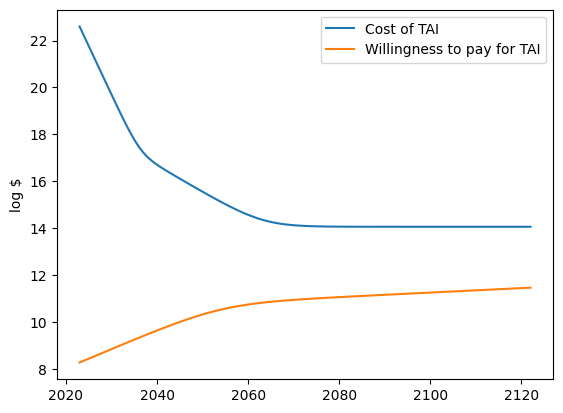

In [10]:
for i in range(50):
    print('-')
    print('-')
    print('## SAMPLE RUN {} ##'.format(i + 3 + 1))
    define_tai_timeline_event(verbose=True)